## Libraries and data imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from astropy.timeseries import LombScargle
import pymc as pm
import arviz as az
def load_data(y_lim=None): # y_lim == max year BP range [0, y_lim]
    df = pd.read_excel("./data/d18O NGRIP 21.04.24.xlsx", sheet_name="Raw Data", header=None, engine="openpyxl")
    df = df.iloc[10:6124,2:4]
    df.columns = ["Age", "d18o"]
    if y_lim is not None:
        df = df[df["Age"] <= y_lim]
    df["d18o"] -= np.mean(df["d18o"])       # center data
    t = df["Age"].values.astype("float")
    y = df["d18o"].values.astype("float")
    return t, y
def load_borneo(y_lim=None):
    df = pd.read_excel("./data/Borneo Stalagmite 02.04.25.xlsx", header=None, engine="openpyxl")
    df = df.iloc[10:,1:3]
    df.columns = ["Age", "d18o"]
    if y_lim is not None:
        df = df[df["Age"] <= y_lim]
    df["d18o"] -= np.mean(df["d18o"])       # center data
    t = df["Age"].values.astype("float")
    y = df["d18o"].values.astype("float")
    return t, y

## Main function

In [5]:
def interactive_fit(t, y, Pmin=400, Pmax=30000, l_s=True, n_samples=2000, 
                    n_tune=1000, n_chains=4, target_accept=0.95):
    # --- Initialize storage --- 
    res = y.copy()
    harmonics = []
    tot_fits  = []
    # --- First while loop: main iteration --- 
    while True:
        plt.close('all')
    # --- 1. Compute periodogram of residuals --- 
        if l_s: f, I, peaks = l_s_periodogram(t, res, Pmin=Pmin, Pmax=Pmax); I*=1000
        else:   f, I, peaks = fourier_periods(t, res)
        potential_P = 1/f[peaks]
        potential_I = I[peaks]
    # --- 2. Plot periodogram with peaks --- 
        plot_periodogram(t, res, f, I, peaks)
    # --- 3. Ask user for period selection  --- 
        fitted_periods = [fit['period'] for fit in tot_fits]
        user_input, d_harmonic, picked_P, period1, period2 = peak_selector_user(potential_P, potential_I, fitted_periods)
    # --- Exit condition --- 
        if user_input == "-1":
            print("Finished fitting.")
            break
        if user_input is None: continue  # invalid input, restart loop

    # --- Second while loop: fit checking ---         
        while True:
            # --- Single harmonic mode ---
            if not d_harmonic:          
                (A_hat, s_A_hat, P_hat, s_P_hat, phi_hat, s_phi_hat), trace = fit_harmonic(t, res,
                                                                                           P_guess=picked_P,
                                                                                           n_samples=n_samples,
                                                                                           n_tune=n_tune,
                                                                                           n_chains=n_chains,
                                                                                           target_accept=target_accept
                                                                                          )
                harmonic = A_hat * np.cos(2*np.pi/P_hat * t + phi_hat)                
            # --- Double Harmonic mode ---
            else:
                (A1, s_A1, P1, s_P1, phi1, s_phi1,
                 A2, s_A2, P2, s_P2, phi2, s_phi2), trace = fit_d_harmonic(t, res,
                                                                           P1_guess=period1,
                                                                           P2_guess=period2,
                                                                           n_samples=n_samples,
                                                                           n_tune=n_tune,
                                                                           n_chains=n_chains,
                                                                           target_accept=target_accept 
                                                                          )
                harmonic1 = A1 * np.cos(2*np.pi/P1 * t + phi1)
                harmonic2 = A2 * np.cos(2*np.pi/P2 * t + phi2)
                harmonic = harmonic1 + harmonic2
        
            # --- Plotting ---
            if not d_harmonic: plot_model(t, y, res, harmonics, harmonic, d_harmonic=False, P_hat=P_hat)
            else: plot_model(t, y, res, harmonics, (harmonic1, harmonic2), d_harmonic=True, P1=P1, P2=P2)
        
            # --- Control = Confirm / Discard / Remake ---
            print("\n------------------------------------")
            control = input("Keep this result? (y/n/r): r = remake same values : ").strip().lower()
            print("\n------------------------------------")
        
            if control == 'y':                           # Confirm  
                harmonics.append(harmonic)
                res -= harmonic
        
                if not d_harmonic:
                    tot_fits.append({'period': P_hat, 's_period': s_P_hat, 'amplitude': A_hat,'s_amplitude': s_A_hat,
                                     'phi': phi_hat, 's_phi': s_phi_hat, 'harmonic': harmonic})
                else:
                    tot_fits.append({'period': P1, 's_period': s_P1, 'amplitude': A1, 's_amplitude': s_A1,
                                     'phi': phi1, 's_phi': s_phi1, 'harmonic': harmonic1})
                    tot_fits.append({'period': P2, 's_period': s_P2, 'amplitude': A2, 's_amplitude': s_A2,
                                     'phi': phi2, 's_phi': s_phi2, 'harmonic': harmonic2})
        
                print(f"{'Double ' if d_harmonic else ''}Fit accepted.")
                break
        
            elif control == 'n': break                   # Discard
            elif control == 'r': continue                # Remake
        
            else:
                print("Invalid input. Please enter 'y', 'n', or 'r'")
                continue
    param = pd.DataFrame([{'period': f['period'],'s_period': f['s_period'],'amplitude': f['amplitude'],
                           's_amplitude': f['s_amplitude'],'phi': f['phi'],'s_phi': f['s_phi']} for f in tot_fits])
    return {'residuals': res,'param': param,'final_model': sum(harmonics) if harmonics else np.zeros_like(y)}

## Helper functions

### Plot functions

In [2]:
def plot_periodogram(t, residuals, f, I, peaks):
    valid_idx = f > 0     # Clean fourier plot removing the 1/f error
    fv        = f[valid_idx]
    Iv        = I[valid_idx]
    P         = 1 / f[peaks]
    intensity = I[peaks]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    # --- Periodogram plot --- 
    ax1.plot(1/fv, Iv, 'k-', lw=0.5)
    ax1.plot(P, intensity, 'ro', ms=5)
    ax1.set_xscale('log')
    ax1.set_xlabel('Period')
    ax1.set_ylabel('Power')
    ax1.set_title('Periodogram of Residuals')

    # --- Current residuals --- 
    ax2.plot(t, residuals, 'b.', alpha=0.3, label='Residuals')
    ax2.legend()
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Measurement')
    ax2.set_title('Current Residuals')

    plt.tight_layout()
    plt.show()

In [3]:
def plot_model(t, y, residuals, harmonics, new_harmonic, d_harmonic=False, P_hat=None, P1=None, P2=None):
    """
    Plots:
    - Left: Original data + current full model (existing + new harmonic)
    - Right: Current residuals + new harmonic(s)

    Parameters:
        t: time array
        y: original data
        residuals: current residuals
        harmonics: list of already fitted harmonics
        new_harmonic: newly fitted harmonic. In single mode: array. In double mode: tuple(array, array)
        d_harmonic: whether it's a double harmonic fit
        P_hat: period of single harmonic
        P1, P2: periods of double harmonic
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # --- Ensure new_harmonic is always a flat array ---
    if d_harmonic:
        h1, h2 = new_harmonic
        combined_new = h1 + h2
    else:
        combined_new = new_harmonic

    # --- Left Plot: Data + Full Model ---
    ax1.plot(t, y, 'k.', alpha=0.3, label='Original data')
    total_model = sum(harmonics) + combined_new
    ax1.plot(t, total_model, 'g-', lw=1.5, label='Total model')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Measurement')
    ax1.set_title('Current Model Fit')
    ax1.legend()

    # --- Right Plot: Residuals + New Harmonic(s) ---
    ax2.plot(t, residuals, 'b.', alpha=0.5, label='Current residuals')

    if not d_harmonic:
        ax2.plot(t, new_harmonic, 'r-', lw=2, label=f'New fit (P={P_hat:.2f})')     # Single harmonic
    else:
        h1, h2 = new_harmonic
        ax2.plot(t, h1, 'r--', lw=1, label=f'Fit 1 (P={P1:.2f})')
        ax2.plot(t, h2, 'm--', lw=1, label=f'Fit 2 (P={P2:.2f})')

    ax2.set_xlabel('Time')
    ax2.set_ylabel('Residuals')
    ax2.set_title('New Harmonic Component(s)')
    ax2.legend()

    plt.tight_layout()
    plt.show()

### Main logic helpers

In [4]:
def peak_selector_user(candidate_P, potential_I, fitted_P):
    """
    Presents the top 10 peaks and asks the user for input.
    
    Returns:
        tuple: (
            user_input,
            d_harmonic,
            chosen_P or None,
            period1 or None,
            period2 or None
        )
    """
    print("\n------------------------------------")
    print("\nPossible Peaks sorted by power:")
    sorted_indices = np.argsort(potential_I)[::-1][:10]
    for i, idx in enumerate(sorted_indices):
        print(f"{i}: {candidate_P[idx]:.2f} (power: {potential_I[idx]:.2f})")

    print("\n------------------------------------")
    print(f"\nN inferred harmonics: {len(fitted_P)}")
    if fitted_P:
        print("Of periods:")
        for i, period in enumerate(fitted_P, 1):
            print(f"  {i}: {period:.0f}")

    print("\n------------------------------------")
    user_input = input("\nSelect (0-9)  Use '-1' to finish. Use 'd' to switch to double harmonics mode: ").strip()
    d_harmonic = False
    chosen_P   = None
    period1    = None
    period2    = None

    if user_input == "-1": return user_input, d_harmonic, chosen_P, period1, period2  # 1) exit condition
    elif user_input.lower() == 'd':                                                   # 2) double harmonic condition
        try:
            idx1 = int(input("First peak index (0-9): "))
            idx2 = int(input("Second peak index (0-9): "))
            if not (0 <= idx1 < 10 and 0 <= idx2 < 10):  raise ValueError("Indices must be between 0 and 9")
            selected_idx1 = sorted_indices[idx1]
            selected_idx2 = sorted_indices[idx2]
            period1 = candidate_P[selected_idx1]
            period2 = candidate_P[selected_idx2]
            print(f"\nDouble fit selected: Period1={period1:.2f}, Period2={period2:.2f}")
            d_harmonic = True
        except ValueError as e:
            print(f"Invalid input: {e}. Returning to selection.")
            return None, False, None, None, None  # user_input = None is necessary
    else:                                                                             # 3) single harmonic condition
        try:
            selected_i = int(user_input)
            if selected_i < 0 or selected_i >= len(sorted_indices):   raise ValueError()
            selected_idx = sorted_indices[selected_i]
            chosen_P = candidate_P[selected_idx]
            chosen_Power = potential_I[selected_idx]
            print(f"\nSelected period: {chosen_P:.2f} (power: {chosen_Power:.2f})")
        except ValueError:
            print(f"Invalid input. Please enter 0–{len(sorted_indices)-1}, 'd', or '-1'")
            return None, False, None, None, None
    return user_input, d_harmonic, chosen_P, period1, period2

In [10]:
def save_df(df, filename, file_format="csv"):
    if file_format.lower() == "csv":
        df.to_csv(f"{filename}.csv", index=False)
        print(f"Data saved to {filename}.csv")
    elif file_format.lower() == "excel":
        df.to_excel(f"{filename}.xlsx", index=False)
        print(f"Data saved to {filename}.xlsx")

#### Calc helpers

In [6]:
def fourier_periods(t, y, threshold=0.001, min_peak_distance=None):
    # uniform t and y for fourier transform
    dt  = np.median(np.diff(t))
    t_u = np.arange(t[0], t[-1] + dt, dt)
    y_u = np.interp(t_u, t, y)
    
    # get frequency and peaks
    f     = np.fft.rfftfreq(len(y_u), dt)
    ck    = np.fft.rfft(y_u)
    power = np.abs(ck) ** 2

    # Peak detection with prominence and distance
    if min_peak_distance is None:
        min_peak_distance = max(1, int(len(f) * 0.01))           # Default: 1% of the frequency resolution
    peaks, _ = find_peaks(power,
                          prominence=threshold * np.max(power),  # Scaled by max power
                          distance=min_peak_distance)
    return f, power, peaks

In [7]:
def l_s_periodogram(t, y, Pmin = 400, Pmax=30000):
    fmin = 1 / (1.6*Pmax) # to check over the highest longer delta_t present on the dataset
    fmax = 1 / Pmin
    f = np.linspace(fmin, fmax, 4*len(t))  # Sampling dimension >> Nyquist-Shannon limit (4>>1) 
    I = LombScargle(t, y).power(f)
    peaks, _ = find_peaks(I, prominence=0.001)
    return f,I,peaks

In [8]:
def fit_d_harmonic(t,y,P1_guess,P2_guess,n_samples=1000,n_tune=1000,n_chains=2,target_accept=0.9):
    y_std=y.std()
    P_std= abs(P1_guess-P2_guess)/8                                      # s_P << |P_1-P_2| / 2
    with pm.Model() as harmonic:
        # priors
        A1   = pm.HalfNormal("A1", sigma=2*y_std)
        phi1 = pm.VonMises("phi1", mu=0, kappa=2)                        # range [-pi,pi]
        #phi1 = pm.Uniform("phi1", lower=0, upper=2*np.pi)               # alternative a vonmises 
        P1   = pm.Normal("P1", mu=P1_guess, sigma=P_std)        
        A2   = pm.HalfNormal("A2", sigma=2*y_std)
        phi2 = pm.VonMises("phi2", mu=0, kappa=2)                        # range [-pi,pi]
        #phi2 = pm.Uniform("phi2", lower=0, upper=2*np.pi)  
        P2   = pm.Normal("P2", mu=P2_guess, sigma=P_std)     
        sig = pm.HalfNormal("sigma", sigma=2*y_std)
        #likelihood
        mu   = A1 * pm.math.cos(2 * np.pi * t / P1 + phi1) + A2 * pm.math.cos(2 * np.pi * t / P2 + phi2)
        pm.Normal("y_obs", mu=mu, sigma=sig, observed=y)

        trace = pm.sample(n_samples, tune=n_tune, chains=n_chains,
                          cores=min(4, n_chains),
                          target_accept=target_accept,
                          return_inferencedata=True
                         ) 
        A1_hat     = trace.posterior["A1"].mean().item()
        P1_hat     = trace.posterior["P1"].mean().item()
        phi1_hat   = trace.posterior["phi1"].mean().item()
        phi1_hat   = (phi1_hat + 2 * np.pi) % (2 * np.pi)
        s_A1_hat   = trace.posterior["A1"].std().item()
        s_P1_hat   = trace.posterior["P1"].std().item()
        s_phi1_hat = trace.posterior["phi1"].std().item()
        A2_hat     = trace.posterior["A2"].mean().item()
        P2_hat     = trace.posterior["P2"].mean().item()
        phi2_hat   = trace.posterior["phi2"].mean().item()
        phi2_hat   = (phi2_hat + 2 * np.pi) % (2 * np.pi)
        s_A2_hat   = trace.posterior["A2"].std().item()
        s_P2_hat   = trace.posterior["P2"].std().item()
        s_phi2_hat = trace.posterior["phi2"].std().item()
    # Plot the MCMC chains    az.plot_trace(trace) # DO NOT USE TOO SLOW
    # Generate a summary of the posterior distributions
    print(az.summary(trace))
    return (A1_hat, s_A1_hat, P1_hat, s_P1_hat, phi1_hat, s_phi1_hat,
            A2_hat, s_A2_hat, P2_hat, s_P2_hat, phi2_hat, s_phi2_hat), trace

In [9]:
def fit_harmonic(t, y, P_guess, n_samples=1000, n_tune=1000, n_chains=2, target_accept=0.95):
    y_std = y.std()
    with pm.Model() as harmonic:
        # priors
        A = pm.HalfNormal("A", sigma=2*y_std)
        phi = pm.VonMises("phi", mu=0, kappa=2)                          # range [-pi,pi]
        #phi = pm.Uniform("phi", lower=0, upper=2*np.pi)
        sig = pm.HalfNormal("sigma", sigma=y_std)
        P = pm.Normal("P", mu=P_guess, sigma=0.03*P_guess)
        #likelihood
        mu = A * pm.math.cos(2*np.pi * t / P + phi)
        pm.Normal("y_obs", mu=mu, sigma=sig, observed=y)

        trace = pm.sample(n_samples, tune=n_tune, chains=n_chains,
                          cores=min(4, n_chains),
                          target_accept=target_accept,
                          return_inferencedata=True
                         )        
    A_hat     = trace.posterior["A"].mean().item()
    P_hat     = trace.posterior["P"].mean().item()
    phi_hat   = trace.posterior["phi"].mean().item()
    phi_hat   = (phi_hat + 2 * np.pi) % (2 * np.pi)                      # Shift [-pi,pi] to [0,2pi]
    s_A_hat   = trace.posterior["A"].std().item()
    s_P_hat   = trace.posterior["P"].std().item()
    s_phi_hat = trace.posterior["phi"].std().item()
    # Print Summary of mcmc
    print(az.summary(trace))
    return (A_hat, s_A_hat, P_hat, s_P_hat, phi_hat, s_phi_hat), trace

## Pipeline

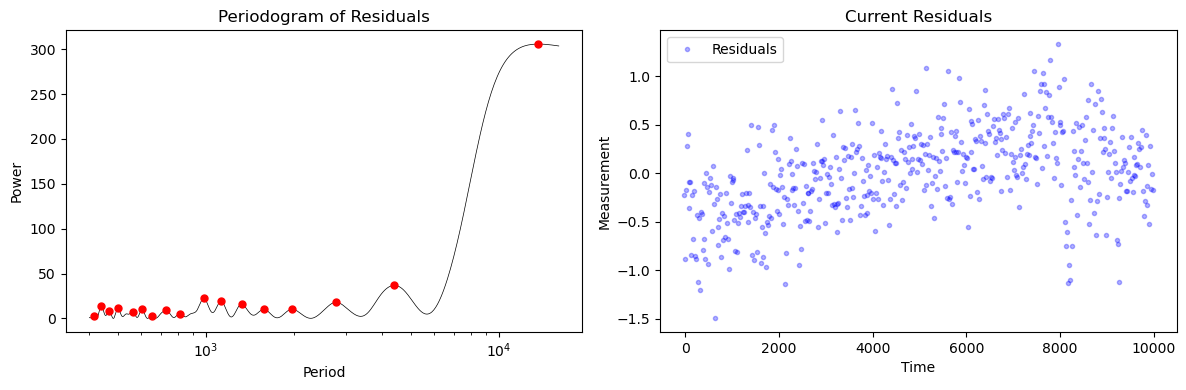


------------------------------------

Possible Peaks sorted by power:
0: 13618.32 (power: 305.77)
1: 4392.29 (power: 36.81)
2: 983.19 (power: 22.59)
3: 1125.67 (power: 18.99)
4: 2777.37 (power: 17.98)
5: 1322.79 (power: 16.02)
6: 439.73 (power: 14.08)
7: 501.01 (power: 11.10)
8: 1967.65 (power: 10.32)
9: 1575.97 (power: 10.18)

------------------------------------

N inferred harmonics: 0

------------------------------------



Select (0-9)  Use '-1' to finish. Use 'd' to switch to double harmonics mode:  0


Initializing NUTS using jitter+adapt_diag...



Selected period: 13618.32 (power: 305.77)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, phi, sigma, P]


Output()

Sampling 4 chains for 20_000 tune and 50_000 draw iterations (80_000 + 200_000 draws total) took 63 seconds.


            mean       sd     hdi_3%    hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
P      13031.448  368.256  12346.242  13731.298      1.002    0.781  135042.0   
A          0.325    0.024      0.281      0.370      0.000    0.000  179036.0   
phi        2.775    1.024      2.771      3.141      0.003    0.007  147716.0   
sigma      0.375    0.012      0.353      0.398      0.000    0.000  167182.0   

       ess_tail  r_hat  
P      140629.0    1.0  
A      131399.0    1.0  
phi    136731.0    1.0  
sigma  138559.0    1.0  


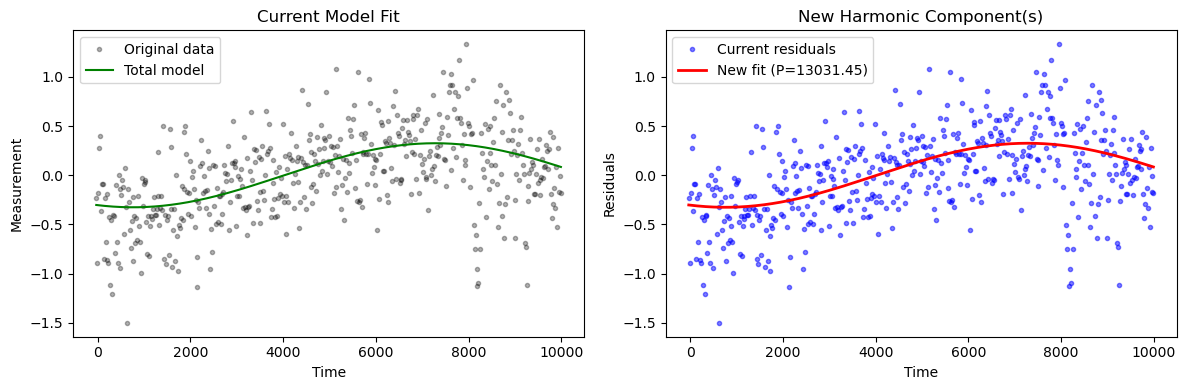


------------------------------------


Keep this result? (y/n/r): r = remake same values :  y



------------------------------------
Fit accepted.


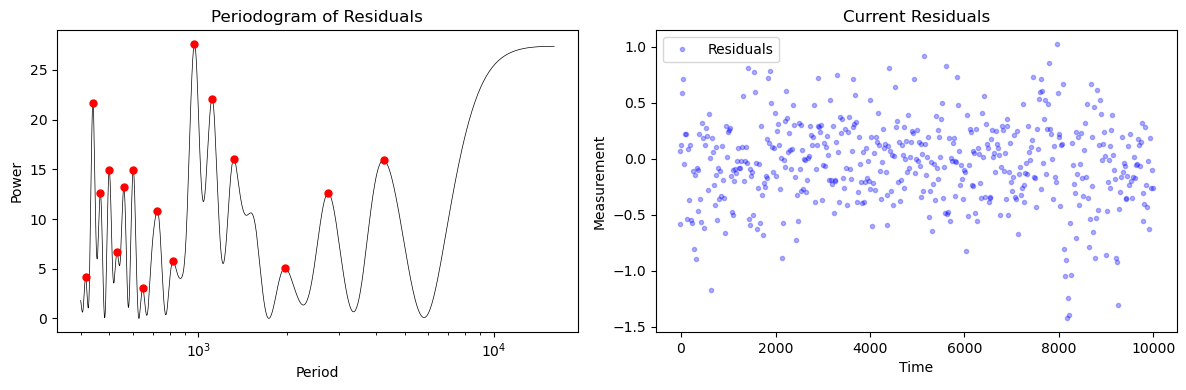


------------------------------------

Possible Peaks sorted by power:
0: 970.44 (power: 27.60)
1: 1113.49 (power: 22.10)
2: 439.97 (power: 21.69)
3: 1318.55 (power: 16.06)
4: 4234.18 (power: 15.92)
5: 602.57 (power: 14.96)
6: 499.79 (power: 14.93)
7: 559.95 (power: 13.19)
8: 2749.55 (power: 12.60)
9: 466.38 (power: 12.59)

------------------------------------

N inferred harmonics: 1
Of periods:
  1: 13031

------------------------------------



Select (0-9)  Use '-1' to finish. Use 'd' to switch to double harmonics mode:  0


Initializing NUTS using jitter+adapt_diag...



Selected period: 970.44 (power: 27.60)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, phi, sigma, P]


Output()

Sampling 4 chains for 20_000 tune and 50_000 draw iterations (80_000 + 200_000 draws total) took 76 seconds.


          mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
P      968.535  11.670  946.664  990.440      0.038    0.042   97649.0   
A        0.081   0.025    0.034    0.127      0.000    0.000   81920.0   
phi      0.211   0.529   -0.781    1.214      0.002    0.002   97826.0   
sigma    0.372   0.012    0.350    0.394      0.000    0.000  135479.0   

       ess_tail  r_hat  
P      103774.0    1.0  
A       50334.0    1.0  
phi    105221.0    1.0  
sigma  124117.0    1.0  


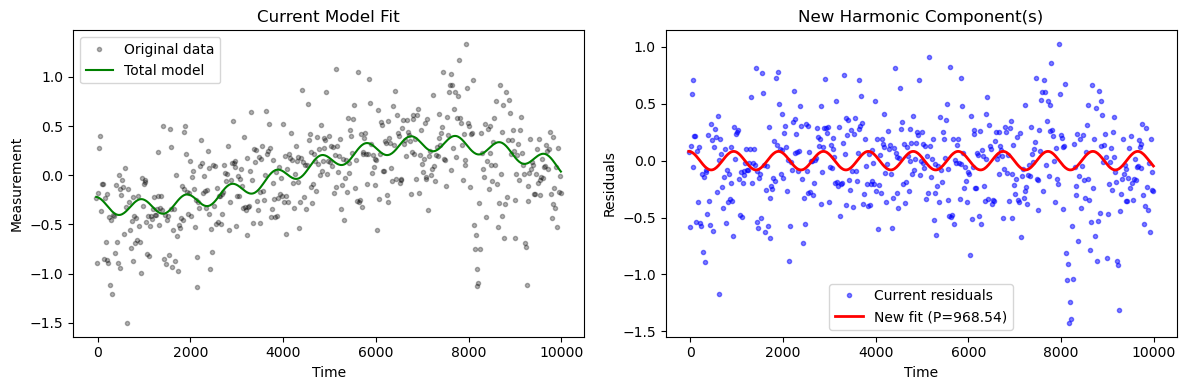


------------------------------------


Keep this result? (y/n/r): r = remake same values :  y



------------------------------------
Fit accepted.


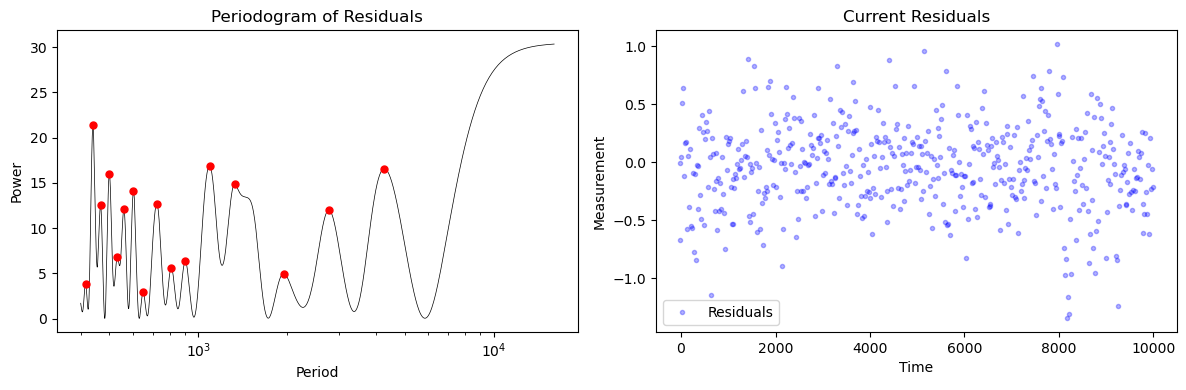


------------------------------------

Possible Peaks sorted by power:
0: 440.20 (power: 21.36)
1: 1091.35 (power: 16.88)
2: 4256.06 (power: 16.58)
3: 500.09 (power: 16.04)
4: 1329.19 (power: 14.87)
5: 603.45 (power: 14.08)
6: 723.24 (power: 12.72)
7: 466.91 (power: 12.53)
8: 559.95 (power: 12.11)
9: 2768.04 (power: 11.99)

------------------------------------

N inferred harmonics: 2
Of periods:
  1: 13031
  2: 969

------------------------------------



Select (0-9)  Use '-1' to finish. Use 'd' to switch to double harmonics mode:  y


Invalid input. Please enter 0–9, 'd', or '-1'


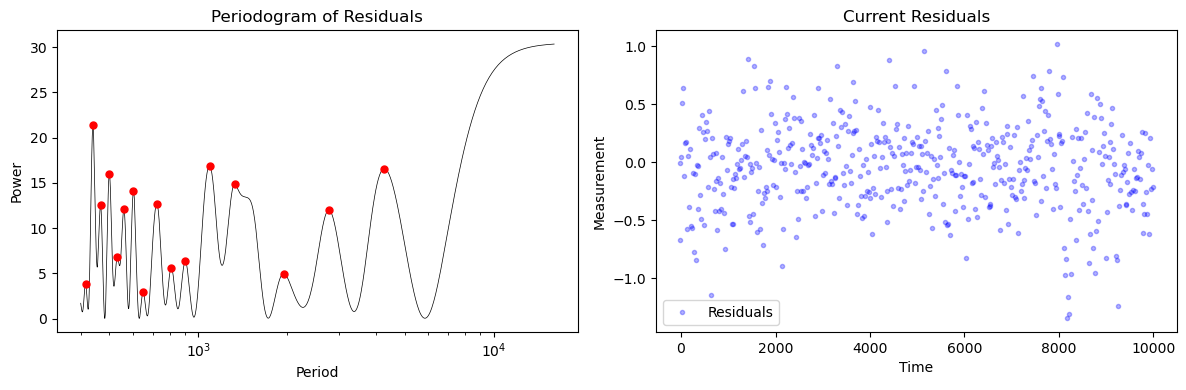


------------------------------------

Possible Peaks sorted by power:
0: 440.20 (power: 21.36)
1: 1091.35 (power: 16.88)
2: 4256.06 (power: 16.58)
3: 500.09 (power: 16.04)
4: 1329.19 (power: 14.87)
5: 603.45 (power: 14.08)
6: 723.24 (power: 12.72)
7: 466.91 (power: 12.53)
8: 559.95 (power: 12.11)
9: 2768.04 (power: 11.99)

------------------------------------

N inferred harmonics: 2
Of periods:
  1: 13031
  2: 969

------------------------------------



Select (0-9)  Use '-1' to finish. Use 'd' to switch to double harmonics mode:  0


Initializing NUTS using jitter+adapt_diag...



Selected period: 440.20 (power: 21.36)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, phi, sigma, P]


Output()

Sampling 4 chains for 20_000 tune and 50_000 draw iterations (80_000 + 200_000 draws total) took 102 seconds.


          mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
P      444.544  8.382  434.688  467.307      0.056    0.073   31671.0   
A        0.059  0.027    0.004    0.104      0.000    0.000   31185.0   
phi     -0.894  0.655   -2.092    0.323      0.003    0.003   38060.0   
sigma    0.369  0.012    0.348    0.392      0.000    0.000   95890.0   

       ess_tail  r_hat  
P       21583.0    1.0  
A       26360.0    1.0  
phi     44099.0    1.0  
sigma  103099.0    1.0  


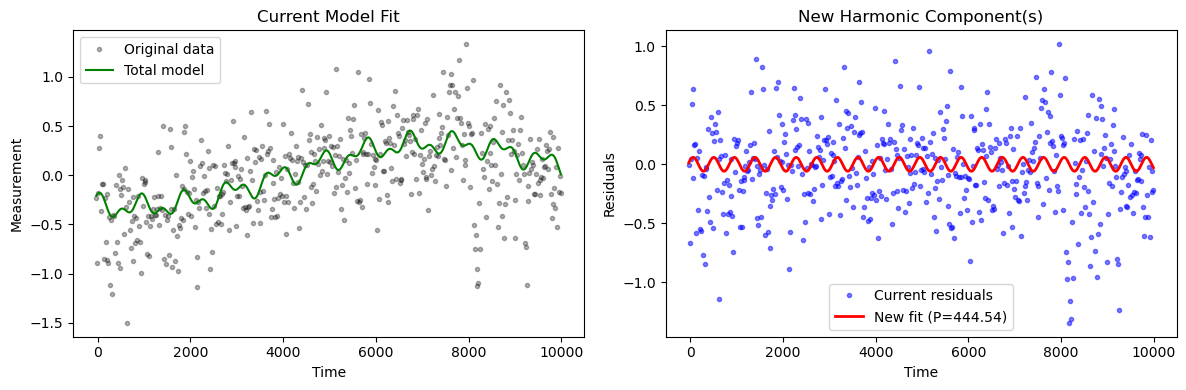


------------------------------------


Keep this result? (y/n/r): r = remake same values :  y



------------------------------------
Fit accepted.


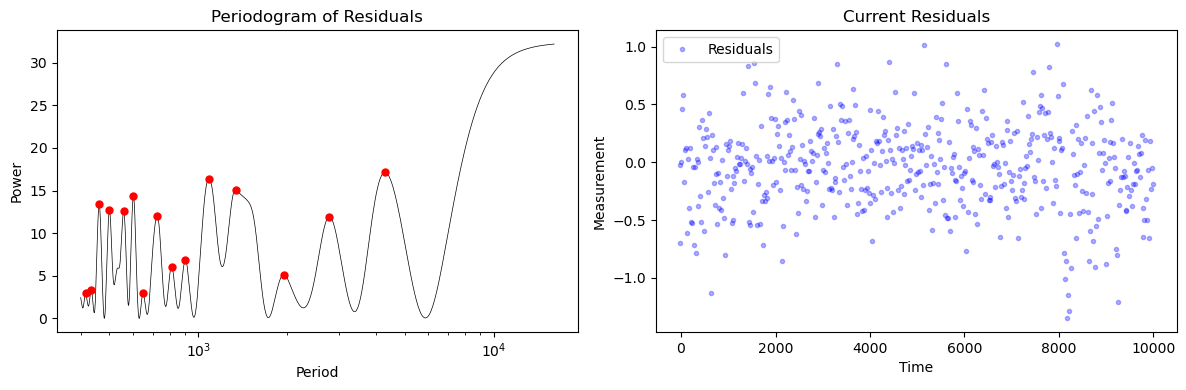


------------------------------------

Possible Peaks sorted by power:
0: 4278.18 (power: 17.14)
1: 1087.03 (power: 16.41)
2: 1340.01 (power: 15.12)
3: 603.45 (power: 14.34)
4: 461.94 (power: 13.37)
5: 500.40 (power: 12.72)
6: 559.19 (power: 12.61)
7: 725.79 (power: 12.05)
8: 2777.37 (power: 11.93)
9: 904.36 (power: 6.81)

------------------------------------

N inferred harmonics: 3
Of periods:
  1: 13031
  2: 969
  3: 445

------------------------------------



Select (0-9)  Use '-1' to finish. Use 'd' to switch to double harmonics mode:  0



Selected period: 4278.18 (power: 17.14)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, phi, sigma, P]


Output()

Sampling 4 chains for 20_000 tune and 50_000 draw iterations (80_000 + 200_000 draws total) took 87 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.


           mean       sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
P      4231.622  116.441  4012.548  4450.324      0.372    0.279   98318.0   
A         0.066    0.026     0.015     0.115      0.000    0.000   62733.0   
phi       1.713    0.586     0.763     2.723      0.003    0.004   65821.0   
sigma     0.366    0.012     0.344     0.387      0.000    0.000   93968.0   

       ess_tail  r_hat  
P      109211.0    1.0  
A       30273.0    1.0  
phi     40977.0    1.0  
sigma  103863.0    1.0  


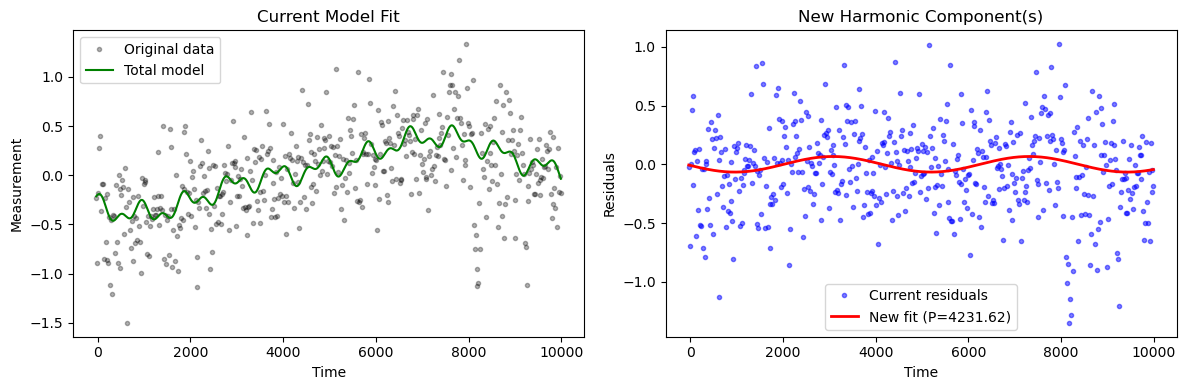


------------------------------------


Keep this result? (y/n/r): r = remake same values :  y



------------------------------------
Fit accepted.



------------------------------------

Possible Peaks sorted by power:
0: 1081.32 (power: 16.80)
1: 1353.22 (power: 14.71)
2: 603.45 (power: 14.38)
3: 462.20 (power: 13.56)
4: 500.40 (power: 12.97)
5: 559.19 (power: 12.48)
6: 723.88 (power: 11.98)
7: 2844.54 (power: 9.07)
8: 906.35 (power: 7.24)
9: 1967.65 (power: 6.17)

------------------------------------

N inferred harmonics: 4
Of periods:
  1: 13031
  2: 969
  3: 445
  4: 4232

------------------------------------



Select (0-9)  Use '-1' to finish. Use 'd' to switch to double harmonics mode:  0



Selected period: 1081.32 (power: 16.80)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, phi, sigma, P]


Output()

Sampling 4 chains for 20_000 tune and 50_000 draw iterations (80_000 + 200_000 draws total) took 88 seconds.


           mean      sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
P      1091.443  18.718  1056.066  1126.385      0.068    0.059   77267.0   
A         0.059   0.024     0.013     0.103      0.000    0.000   66815.0   
phi      -0.191   0.618    -1.371     0.954      0.002    0.002   78024.0   
sigma     0.363   0.011     0.341     0.384      0.000    0.000  121758.0   

       ess_tail  r_hat  
P       89103.0    1.0  
A       37598.0    1.0  
phi     86401.0    1.0  
sigma  119636.0    1.0  


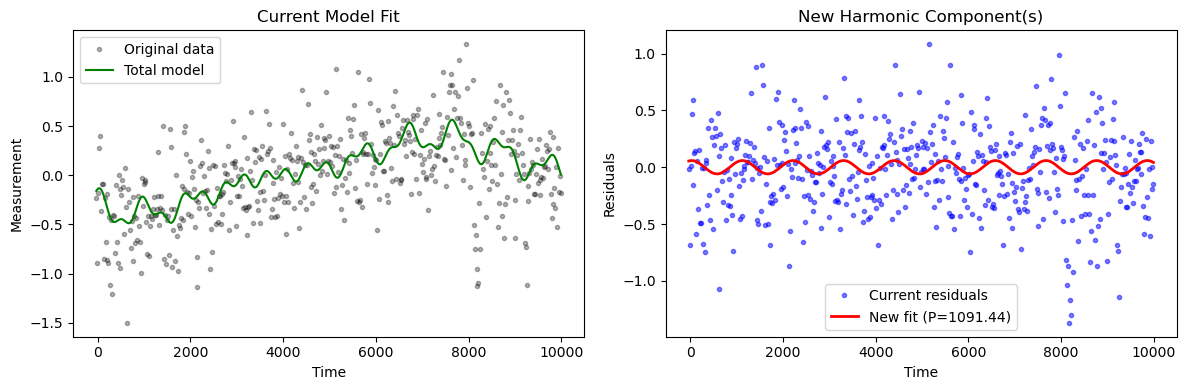


------------------------------------


Keep this result? (y/n/r): r = remake same values :  y



------------------------------------
Fit accepted.


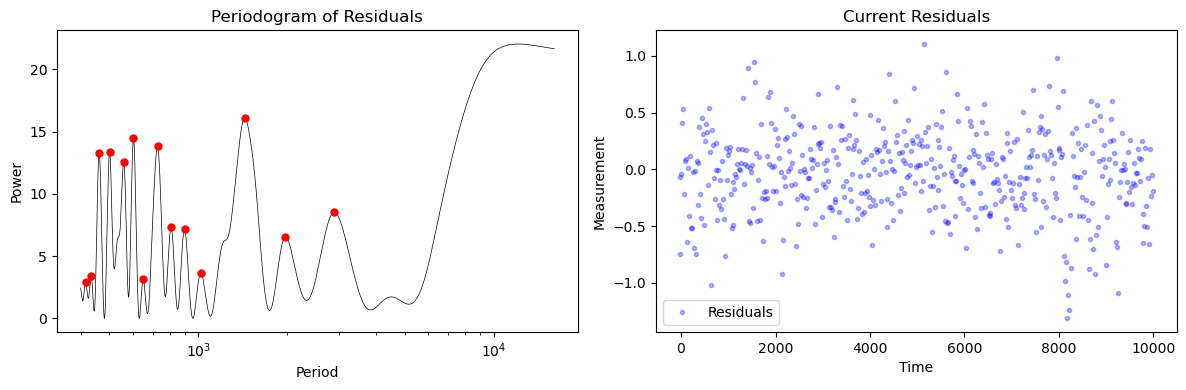


------------------------------------

Possible Peaks sorted by power:
0: 1435.81 (power: 16.11)
1: 603.45 (power: 14.47)
2: 727.72 (power: 13.82)
3: 501.01 (power: 13.37)
4: 461.94 (power: 13.31)
5: 559.19 (power: 12.59)
6: 2884.40 (power: 8.52)
7: 809.25 (power: 7.33)
8: 898.44 (power: 7.15)
9: 1972.36 (power: 6.53)

------------------------------------

N inferred harmonics: 5
Of periods:
  1: 13031
  2: 969
  3: 445
  4: 4232
  5: 1091

------------------------------------



Select (0-9)  Use '-1' to finish. Use 'd' to switch to double harmonics mode:  0



Selected period: 1435.81 (power: 16.11)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, phi, sigma, P]


Output()

Sampling 4 chains for 20_000 tune and 50_000 draw iterations (80_000 + 200_000 draws total) took 118 seconds.


           mean      sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
P      1469.880  36.795  1401.577  1537.868      0.169    0.179   54765.0   
A         0.054   0.024     0.004     0.096      0.000    0.000   53115.0   
phi      -0.815   0.865    -2.537     0.602      0.003    0.004   74661.0   
sigma     0.360   0.011     0.339     0.382      0.000    0.000   98860.0   

       ess_tail  r_hat  
P       43255.0    1.0  
A       31592.0    1.0  
phi     53500.0    1.0  
sigma  105108.0    1.0  



------------------------------------


Keep this result? (y/n/r): r = remake same values :  y



------------------------------------
Fit accepted.


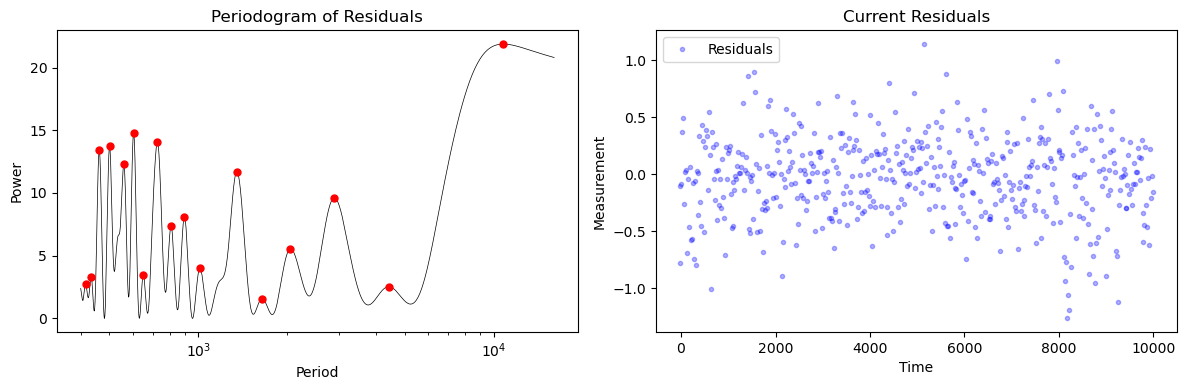


------------------------------------

Possible Peaks sorted by power:
0: 10768.61 (power: 21.87)
1: 604.34 (power: 14.82)
2: 727.08 (power: 14.05)
3: 501.01 (power: 13.73)
4: 462.20 (power: 13.41)
5: 559.57 (power: 12.30)
6: 1351.00 (power: 11.70)
7: 2884.40 (power: 9.60)
8: 897.46 (power: 8.08)
9: 809.25 (power: 7.36)

------------------------------------

N inferred harmonics: 6
Of periods:
  1: 13031
  2: 969
  3: 445
  4: 4232
  5: 1091
  6: 1470

------------------------------------



Select (0-9)  Use '-1' to finish. Use 'd' to switch to double harmonics mode:  0


Initializing NUTS using jitter+adapt_diag...



Selected period: 10768.61 (power: 21.87)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, phi, sigma, P]


Output()

Sampling 4 chains for 20_000 tune and 50_000 draw iterations (80_000 + 200_000 draws total) took 153 seconds.


            mean       sd     hdi_3%    hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
P      10739.565  323.767  10131.643  11346.527      1.016    0.801  101588.0   
A          0.059    0.027      0.000      0.100      0.000    0.000   39867.0   
phi       -1.916    0.831     -3.075     -0.516      0.004    0.006   48570.0   
sigma      0.357    0.011      0.336      0.379      0.000    0.000  112794.0   

       ess_tail  r_hat  
P      110163.0    1.0  
A       27835.0    1.0  
phi     35704.0    1.0  
sigma  109953.0    1.0  


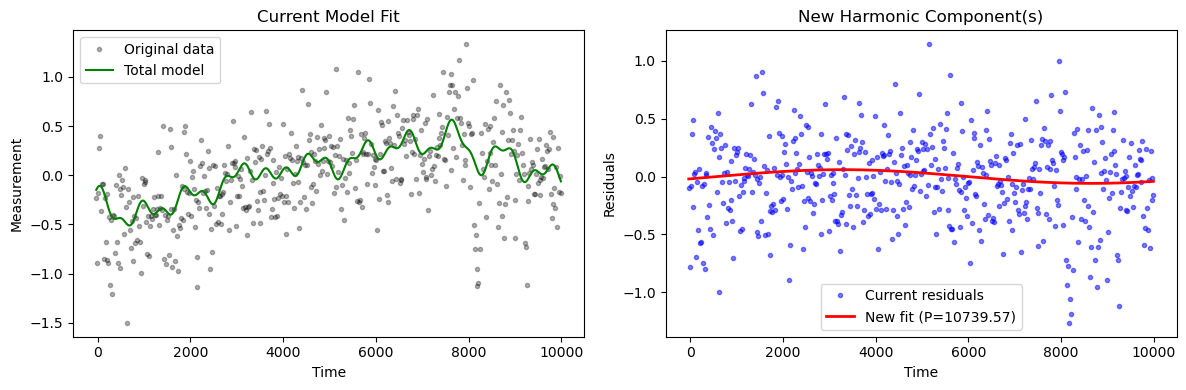


------------------------------------


Keep this result? (y/n/r): r = remake same values :  y



------------------------------------
Fit accepted.



------------------------------------

Possible Peaks sorted by power:
0: 604.34 (power: 15.02)
1: 500.70 (power: 14.10)
2: 725.15 (power: 13.96)
3: 462.46 (power: 13.79)
4: 559.57 (power: 12.33)
5: 1353.22 (power: 10.74)
6: 898.44 (power: 8.09)
7: 2854.40 (power: 7.20)
8: 809.25 (power: 6.91)
9: 2061.24 (power: 6.09)

------------------------------------

N inferred harmonics: 7
Of periods:
  1: 13031
  2: 969
  3: 445
  4: 4232
  5: 1091
  6: 1470
  7: 10740

------------------------------------



Select (0-9)  Use '-1' to finish. Use 'd' to switch to double harmonics mode:  0


Initializing NUTS using jitter+adapt_diag...



Selected period: 604.34 (power: 15.02)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, phi, sigma, P]


Output()

Sampling 4 chains for 20_000 tune and 50_000 draw iterations (80_000 + 200_000 draws total) took 109 seconds.


          mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
P      603.278  9.850  588.405  622.004      0.109    0.198   20303.0   
A        0.052  0.024    0.005    0.094      0.000    0.000   47732.0   
phi      0.072  0.560   -0.975    1.129      0.002    0.002  115752.0   
sigma    0.355  0.011    0.334    0.376      0.000    0.000  109591.0   

       ess_tail  r_hat  
P        5867.0    1.0  
A       34711.0    1.0  
phi    101433.0    1.0  
sigma  109936.0    1.0  


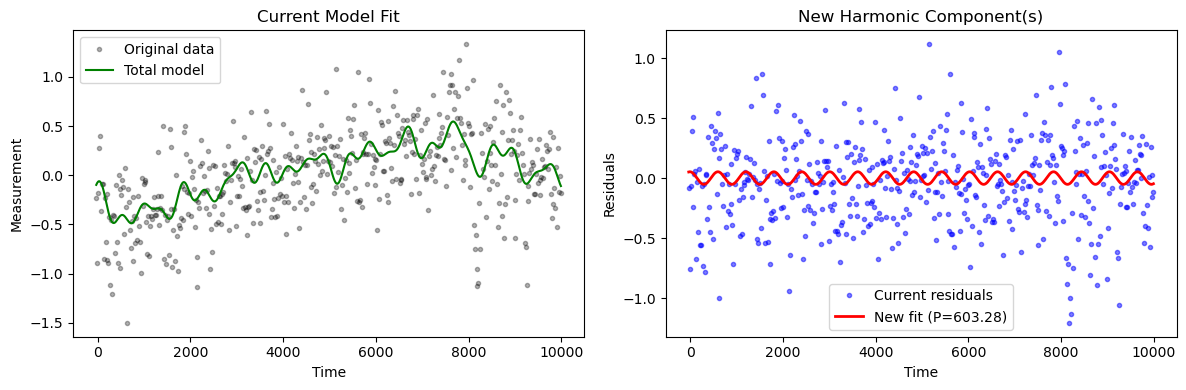


------------------------------------


Keep this result? (y/n/r): r = remake same values :  y



------------------------------------
Fit accepted.


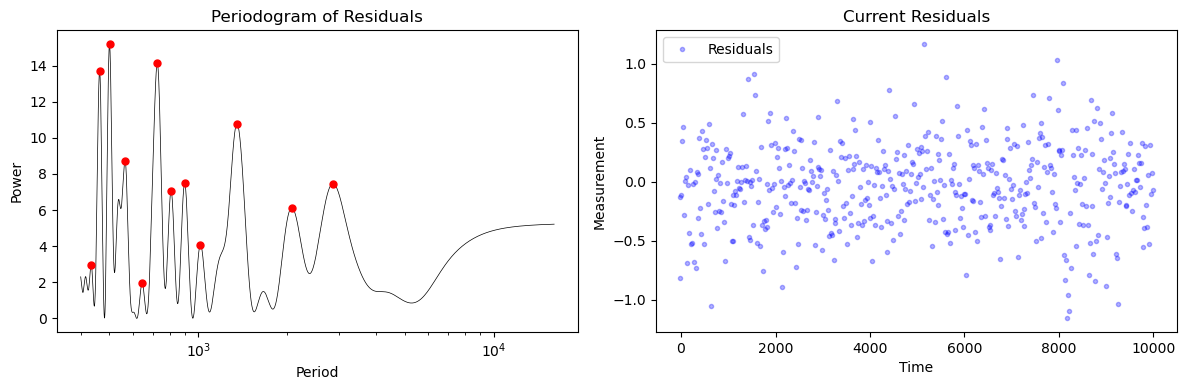


------------------------------------

Possible Peaks sorted by power:
0: 500.70 (power: 15.20)
1: 726.43 (power: 14.14)
2: 463.50 (power: 13.70)
3: 1351.00 (power: 10.78)
4: 564.94 (power: 8.72)
5: 899.42 (power: 7.48)
6: 2854.40 (power: 7.46)
7: 809.25 (power: 7.07)
8: 2071.61 (power: 6.13)
9: 1017.20 (power: 4.09)

------------------------------------

N inferred harmonics: 8
Of periods:
  1: 13031
  2: 969
  3: 445
  4: 4232
  5: 1091
  6: 1470
  7: 10740
  8: 603

------------------------------------



Select (0-9)  Use '-1' to finish. Use 'd' to switch to double harmonics mode:  0


Initializing NUTS using jitter+adapt_diag...



Selected period: 500.70 (power: 15.20)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, phi, sigma, P]


Output()

Sampling 4 chains for 20_000 tune and 50_000 draw iterations (80_000 + 200_000 draws total) took 111 seconds.


          mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
P      497.556  10.010  465.292  509.386      0.116    0.172   13791.0   
A        0.050   0.024    0.002    0.089      0.000    0.000   41255.0   
phi      0.372   0.626   -0.813    1.528      0.003    0.002   53611.0   
sigma    0.353   0.011    0.332    0.374      0.000    0.000  104751.0   

       ess_tail  r_hat  
P        5410.0    1.0  
A       34356.0    1.0  
phi     65329.0    1.0  
sigma  107534.0    1.0  


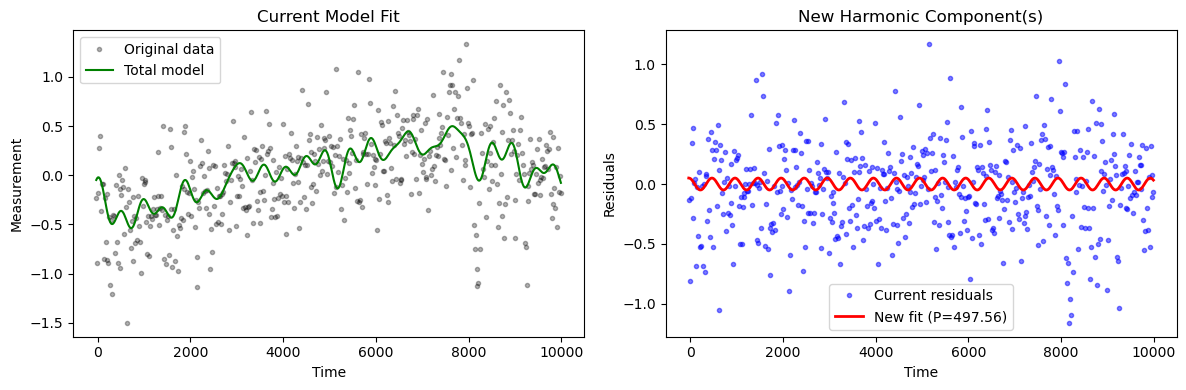


------------------------------------


Keep this result? (y/n/r): r = remake same values :  y



------------------------------------
Fit accepted.


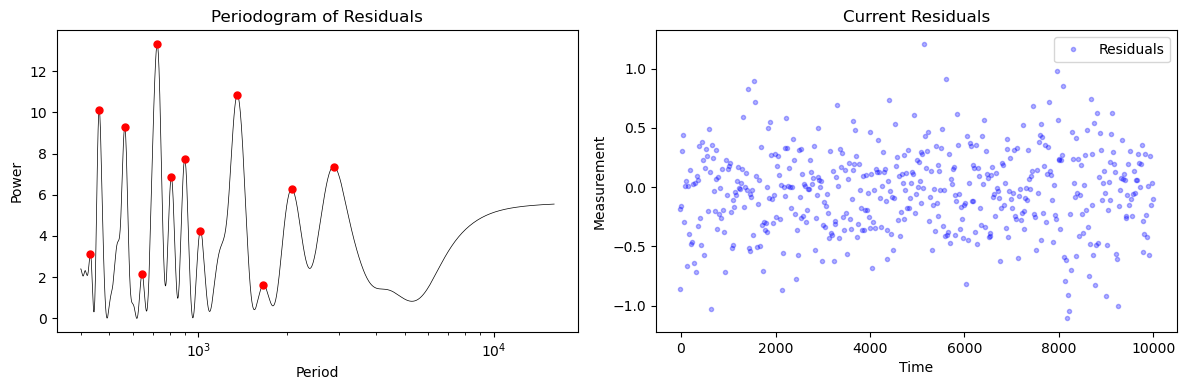


------------------------------------

Possible Peaks sorted by power:
0: 725.79 (power: 13.32)
1: 1355.45 (power: 10.84)
2: 462.20 (power: 10.12)
3: 563.78 (power: 9.28)
4: 899.42 (power: 7.74)
5: 2874.33 (power: 7.37)
6: 810.85 (power: 6.87)
7: 2071.61 (power: 6.28)
8: 1017.20 (power: 4.26)
9: 431.44 (power: 3.13)

------------------------------------

N inferred harmonics: 9
Of periods:
  1: 13031
  2: 969
  3: 445
  4: 4232
  5: 1091
  6: 1470
  7: 10740
  8: 603
  9: 498

------------------------------------



Select (0-9)  Use '-1' to finish. Use 'd' to switch to double harmonics mode:  -1


Finished fitting.


In [11]:
t,y = load_data(y_lim = 10000)
l_s = interactive_fit(t, y, Pmin= 400, Pmax=10000, n_samples=50000, n_tune=20000, target_accept=0.95)

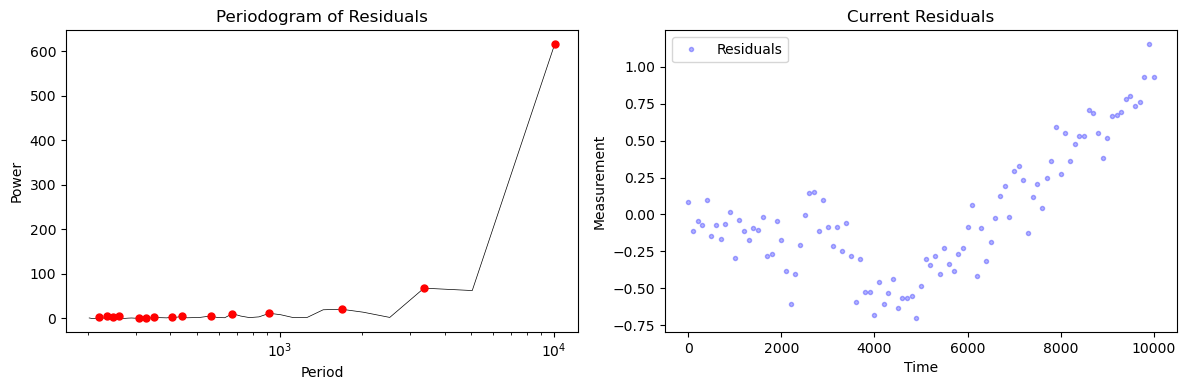


------------------------------------

Possible Peaks sorted by power:
0: 10100.00 (power: 615.96)
1: 3366.67 (power: 67.90)
2: 1683.33 (power: 20.60)
3: 918.18 (power: 11.55)
4: 673.33 (power: 10.74)
5: 234.88 (power: 6.30)
6: 561.11 (power: 5.47)
7: 439.13 (power: 4.77)
8: 258.97 (power: 4.62)
9: 404.00 (power: 3.61)

------------------------------------

N inferred harmonics: 0

------------------------------------



Select (0-9)  Use '-1' to finish. Use 'd' to switch to double harmonics mode:  0


Initializing NUTS using jitter+adapt_diag...



Selected period: 10100.00 (power: 615.96)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, phi, sigma, P]


Output()

Sampling 4 chains for 20_000 tune and 50_000 draw iterations (80_000 + 200_000 draws total) took 47 seconds.


            mean       sd     hdi_3%    hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
P      10718.379  236.839  10267.809  11158.686      0.761    0.528   96965.0   
A          0.507    0.033      0.444      0.570      0.000    0.000  149037.0   
phi        0.839    0.094      0.663      1.015      0.000    0.000   98000.0   
sigma      0.232    0.017      0.200      0.264      0.000    0.000  144275.0   

       ess_tail  r_hat  
P      119938.0    1.0  
A      120456.0    1.0  
phi    112411.0    1.0  
sigma  135987.0    1.0  


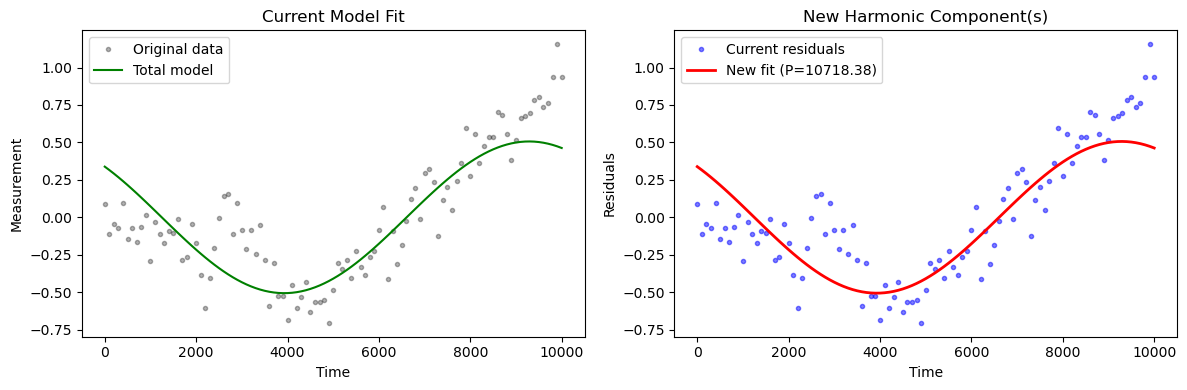


------------------------------------


Keep this result? (y/n/r): r = remake same values :  y



------------------------------------
Fit accepted.


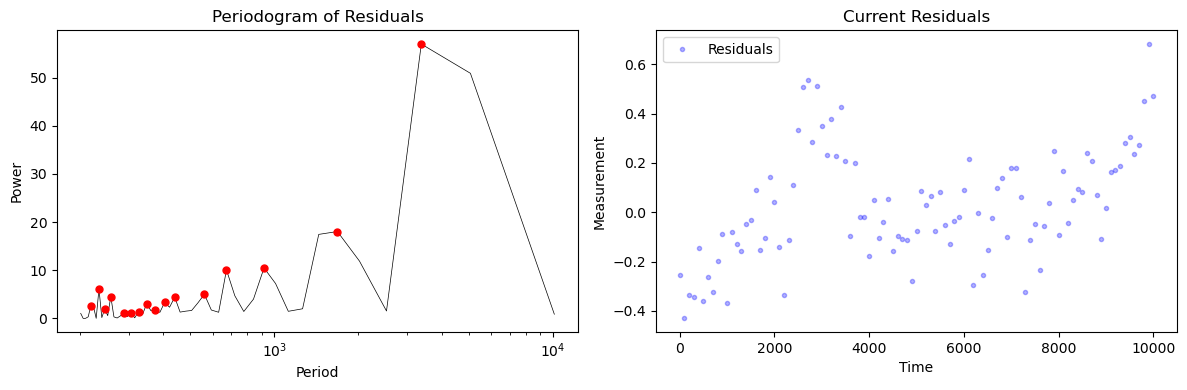


------------------------------------

Possible Peaks sorted by power:
0: 3366.67 (power: 56.94)
1: 1683.33 (power: 18.04)
2: 918.18 (power: 10.48)
3: 673.33 (power: 10.08)
4: 234.88 (power: 6.12)
5: 561.11 (power: 5.01)
6: 258.97 (power: 4.55)
7: 439.13 (power: 4.42)
8: 404.00 (power: 3.33)
9: 348.28 (power: 3.06)

------------------------------------

N inferred harmonics: 1
Of periods:
  1: 10718

------------------------------------



Select (0-9)  Use '-1' to finish. Use 'd' to switch to double harmonics mode:  0


Initializing NUTS using jitter+adapt_diag...



Selected period: 3366.67 (power: 56.94)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, phi, sigma, P]


Output()

Sampling 4 chains for 20_000 tune and 50_000 draw iterations (80_000 + 200_000 draws total) took 49 seconds.


           mean      sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
P      3424.990  72.218  3288.290  3560.037      0.216    0.159  112341.0   
A         0.148   0.029     0.093     0.203      0.000    0.000  147918.0   
phi       1.238   0.260     0.751     1.730      0.001    0.001  107561.0   
sigma     0.203   0.015     0.176     0.231      0.000    0.000  149231.0   

       ess_tail  r_hat  
P      128407.0    1.0  
A       98839.0    1.0  
phi    114789.0    1.0  
sigma  131828.0    1.0  


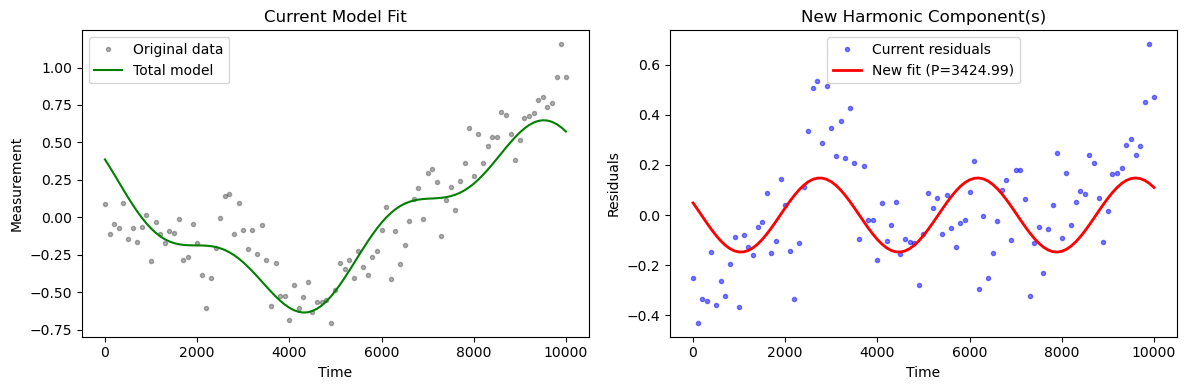


------------------------------------


Keep this result? (y/n/r): r = remake same values :  y



------------------------------------
Fit accepted.


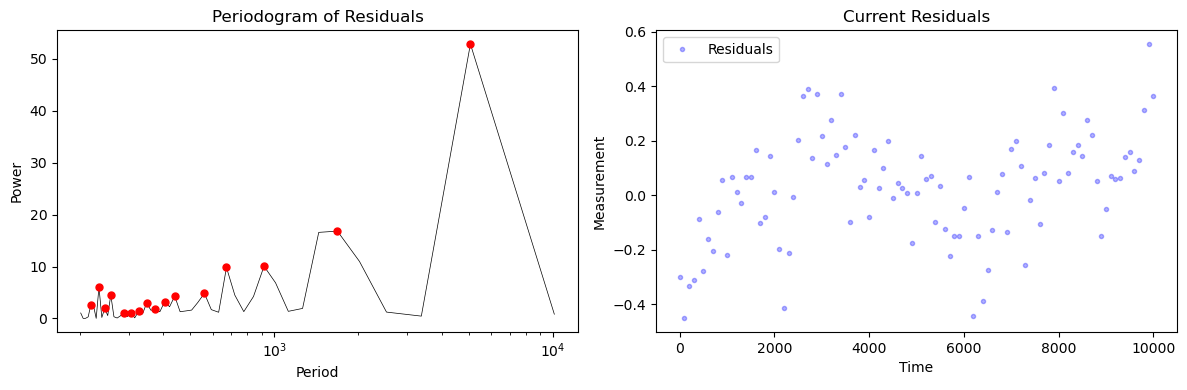


------------------------------------

Possible Peaks sorted by power:
0: 5050.00 (power: 52.88)
1: 1683.33 (power: 16.83)
2: 918.18 (power: 10.07)
3: 673.33 (power: 9.82)
4: 234.88 (power: 6.05)
5: 561.11 (power: 4.85)
6: 258.97 (power: 4.53)
7: 439.13 (power: 4.29)
8: 404.00 (power: 3.23)
9: 348.28 (power: 2.99)

------------------------------------

N inferred harmonics: 2
Of periods:
  1: 10718
  2: 3425

------------------------------------



Select (0-9)  Use '-1' to finish. Use 'd' to switch to double harmonics mode:  0


Initializing NUTS using jitter+adapt_diag...



Selected period: 5050.00 (power: 52.88)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, phi, sigma, P]


Output()

Sampling 4 chains for 20_000 tune and 50_000 draw iterations (80_000 + 200_000 draws total) took 47 seconds.


           mean       sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
P      5272.170  130.719  5027.992  5519.196      0.429    0.284   92914.0   
A         0.150    0.024     0.104     0.196      0.000    0.000  128978.0   
phi       2.244    0.229     1.812     2.673      0.001    0.001   91080.0   
sigma     0.169    0.012     0.146     0.193      0.000    0.000  156349.0   

       ess_tail  r_hat  
P      119956.0    1.0  
A       97259.0    1.0  
phi    107521.0    1.0  
sigma  136209.0    1.0  


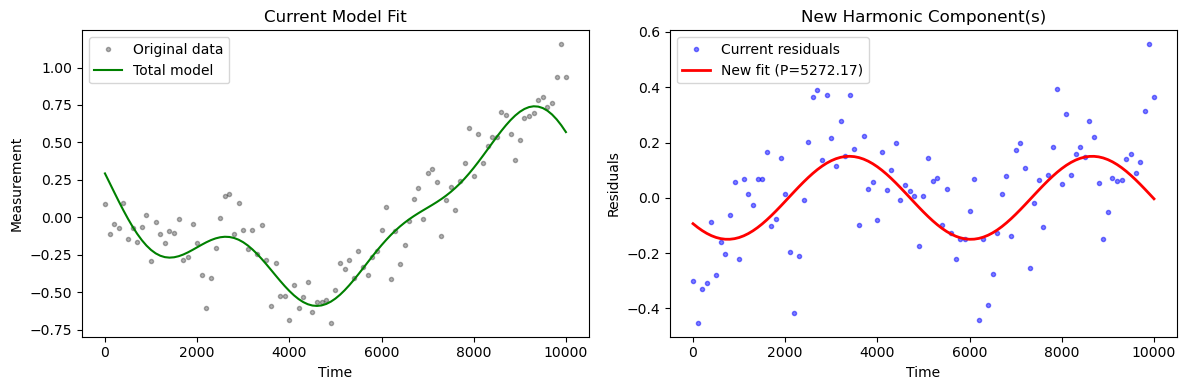


------------------------------------


Keep this result? (y/n/r): r = remake same values :  y



------------------------------------
Fit accepted.


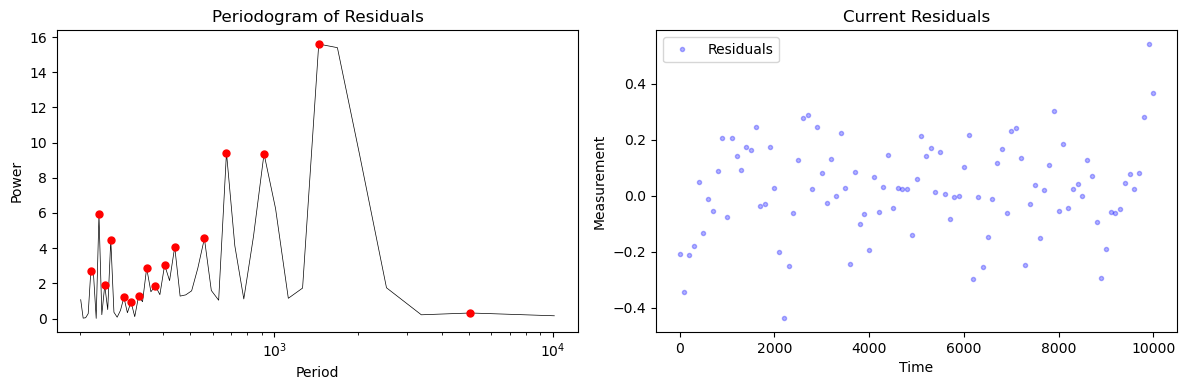


------------------------------------

Possible Peaks sorted by power:
0: 1442.86 (power: 15.60)
1: 673.33 (power: 9.43)
2: 918.18 (power: 9.36)
3: 234.88 (power: 5.93)
4: 561.11 (power: 4.55)
5: 258.97 (power: 4.48)
6: 439.13 (power: 4.07)
7: 404.00 (power: 3.04)
8: 348.28 (power: 2.87)
9: 219.57 (power: 2.68)

------------------------------------

N inferred harmonics: 3
Of periods:
  1: 10718
  2: 3425
  3: 5272

------------------------------------



Select (0-9)  Use '-1' to finish. Use 'd' to switch to double harmonics mode:  0


Initializing NUTS using jitter+adapt_diag...



Selected period: 1442.86 (power: 15.60)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, phi, sigma, P]


Output()

Sampling 4 chains for 20_000 tune and 50_000 draw iterations (80_000 + 200_000 draws total) took 51 seconds.


           mean      sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
P      1421.193  22.934  1378.273  1464.616      0.076    0.072   92839.0   
A         0.073   0.023     0.028     0.117      0.000    0.000   71363.0   
phi       0.505   0.493    -0.427     1.422      0.002    0.001   92790.0   
sigma     0.159   0.011     0.138     0.181      0.000    0.000  133815.0   

       ess_tail  r_hat  
P      104717.0    1.0  
A       41507.0    1.0  
phi    100821.0    1.0  
sigma  120023.0    1.0  


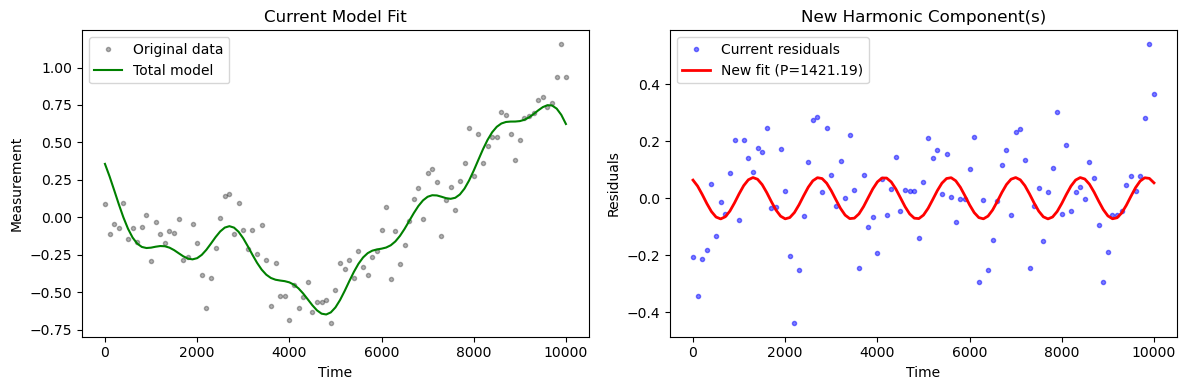


------------------------------------


Keep this result? (y/n/r): r = remake same values :  y



------------------------------------
Fit accepted.


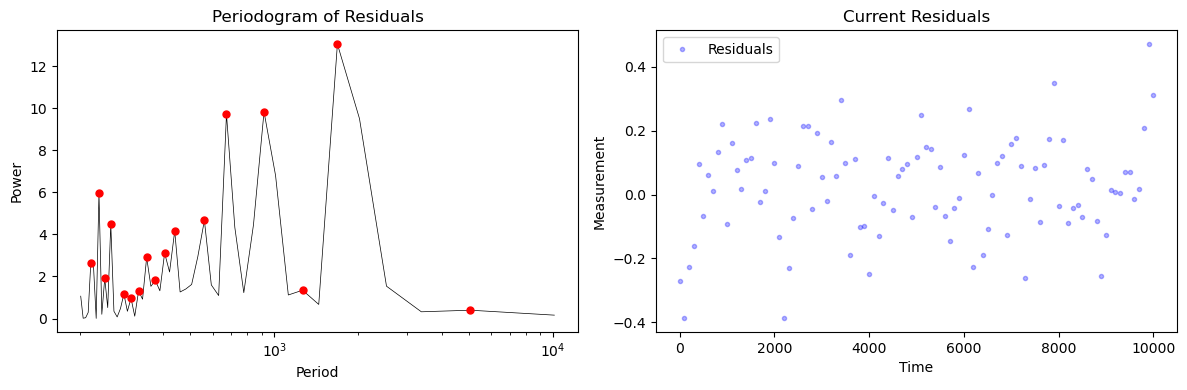


------------------------------------

Possible Peaks sorted by power:
0: 1683.33 (power: 13.04)
1: 918.18 (power: 9.83)
2: 673.33 (power: 9.71)
3: 234.88 (power: 5.98)
4: 561.11 (power: 4.67)
5: 258.97 (power: 4.49)
6: 439.13 (power: 4.17)
7: 404.00 (power: 3.11)
8: 348.28 (power: 2.90)
9: 219.57 (power: 2.65)

------------------------------------

N inferred harmonics: 4
Of periods:
  1: 10718
  2: 3425
  3: 5272
  4: 1421

------------------------------------



Select (0-9)  Use '-1' to finish. Use 'd' to switch to double harmonics mode:  0


Initializing NUTS using jitter+adapt_diag...



Selected period: 1683.33 (power: 13.04)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, phi, sigma, P]


Output()

Sampling 4 chains for 20_000 tune and 50_000 draw iterations (80_000 + 200_000 draws total) took 51 seconds.


           mean      sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
P      1696.367  33.617  1632.361  1759.244      0.115    0.088   86454.0   
A         0.066   0.023     0.021     0.110      0.000    0.000   65993.0   
phi       1.200   0.527     0.193     2.157      0.002    0.002   77542.0   
sigma     0.151   0.011     0.131     0.171      0.000    0.000  109403.0   

       ess_tail  r_hat  
P       95745.0    1.0  
A       39110.0    1.0  
phi     74871.0    1.0  
sigma  117078.0    1.0  


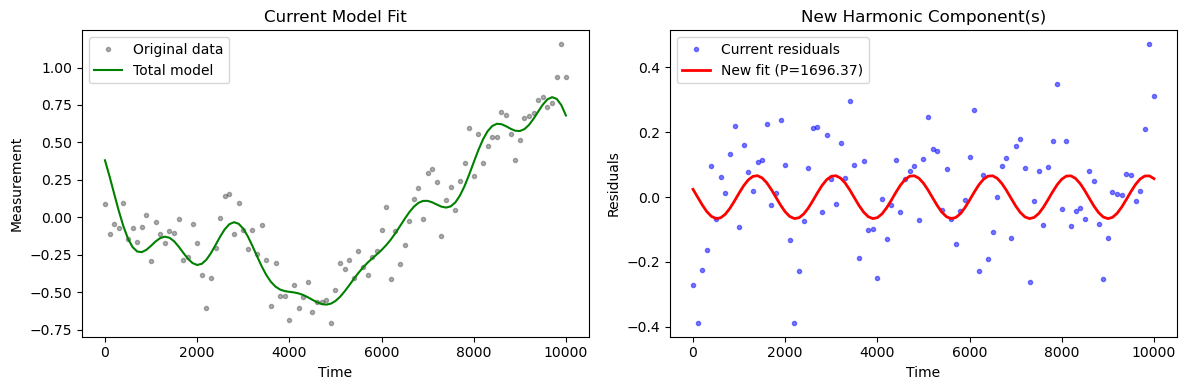


------------------------------------


Keep this result? (y/n/r): r = remake same values :  y



------------------------------------
Fit accepted.


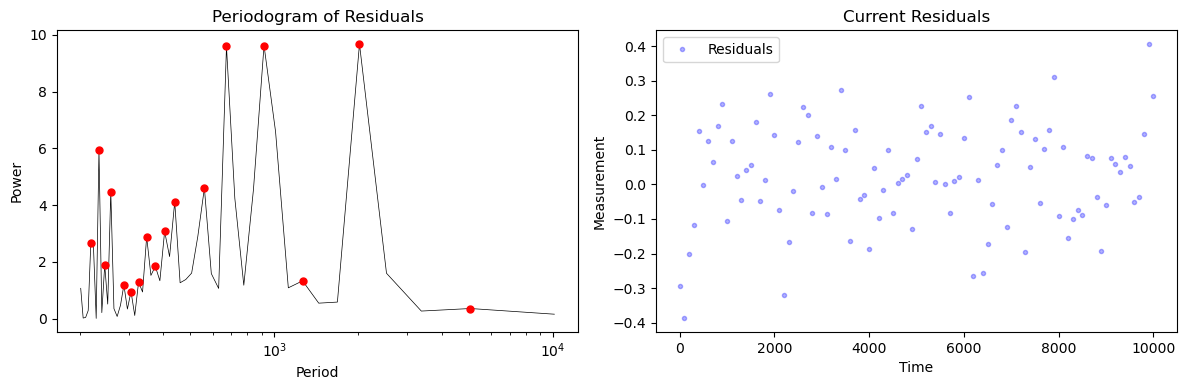


------------------------------------

Possible Peaks sorted by power:
0: 2020.00 (power: 9.68)
1: 918.18 (power: 9.63)
2: 673.33 (power: 9.60)
3: 234.88 (power: 5.95)
4: 561.11 (power: 4.61)
5: 258.97 (power: 4.48)
6: 439.13 (power: 4.12)
7: 404.00 (power: 3.08)
8: 348.28 (power: 2.88)
9: 219.57 (power: 2.67)

------------------------------------

N inferred harmonics: 5
Of periods:
  1: 10718
  2: 3425
  3: 5272
  4: 1421
  5: 1696

------------------------------------



Select (0-9)  Use '-1' to finish. Use 'd' to switch to double harmonics mode:  -1


Finished fitting.


In [13]:
t_b,y_b = load_borneo(y_lim = 10000)
borneo  = interactive_fit(t_b, y_b, Pmin= 400, Pmax=10000, l_s=False, n_samples=50000, n_tune=20000, target_accept=0.95)

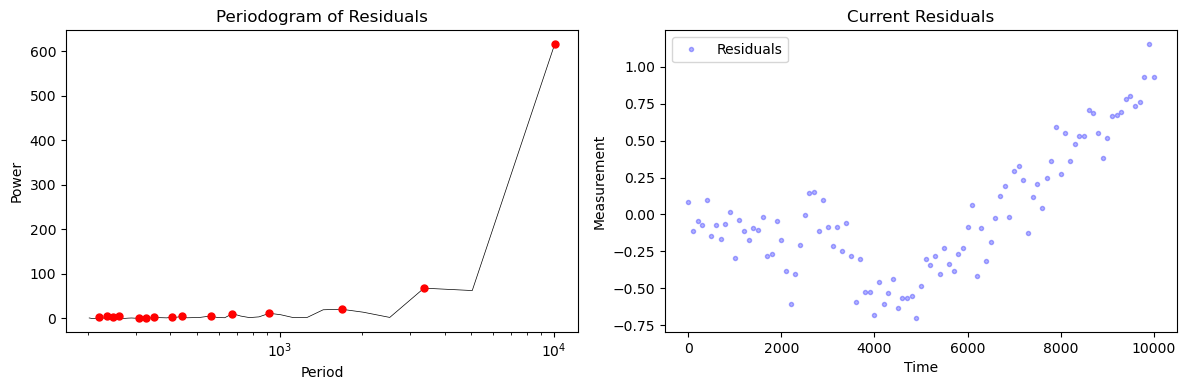


------------------------------------

Possible Peaks sorted by power:
0: 10100.00 (power: 615.96)
1: 3366.67 (power: 67.90)
2: 1683.33 (power: 20.60)
3: 918.18 (power: 11.55)
4: 673.33 (power: 10.74)
5: 234.88 (power: 6.30)
6: 561.11 (power: 5.47)
7: 439.13 (power: 4.77)
8: 258.97 (power: 4.62)
9: 404.00 (power: 3.61)

------------------------------------

N inferred harmonics: 0

------------------------------------



Select (0-9)  Use '-1' to finish. Use 'd' to switch to double harmonics mode:  0


Initializing NUTS using jitter+adapt_diag...



Selected period: 10100.00 (power: 615.96)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, phi, sigma, P]


Output()

Sampling 4 chains for 20_000 tune and 50_000 draw iterations (80_000 + 200_000 draws total) took 48 seconds.


            mean       sd     hdi_3%    hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
P      10718.378  237.375  10271.968  11166.263      0.802    0.536   87765.0   
A          0.506    0.033      0.443      0.568      0.000    0.000  159845.0   
phi        0.839    0.094      0.660      1.013      0.000    0.000   87971.0   
sigma      0.232    0.017      0.200      0.264      0.000    0.000  140013.0   

       ess_tail  r_hat  
P      114588.0    1.0  
A      125621.0    1.0  
phi    109219.0    1.0  
sigma  131445.0    1.0  


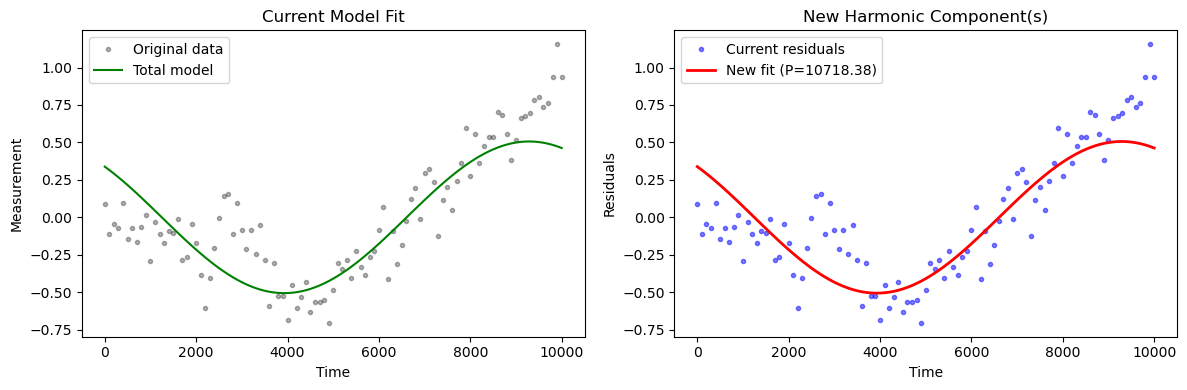


------------------------------------


Keep this result? (y/n/r): r = remake same values :  y



------------------------------------
Fit accepted.


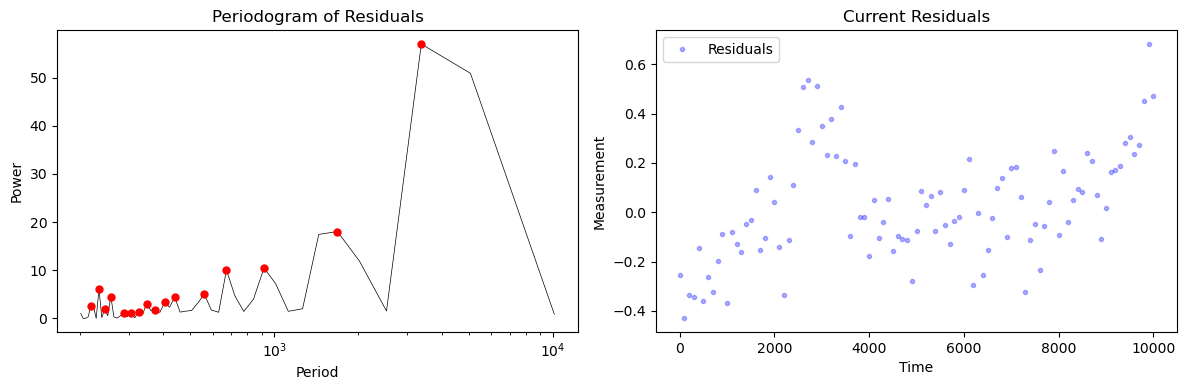


------------------------------------

Possible Peaks sorted by power:
0: 3366.67 (power: 56.95)
1: 1683.33 (power: 18.04)
2: 918.18 (power: 10.48)
3: 673.33 (power: 10.08)
4: 234.88 (power: 6.12)
5: 561.11 (power: 5.02)
6: 258.97 (power: 4.55)
7: 439.13 (power: 4.42)
8: 404.00 (power: 3.33)
9: 348.28 (power: 3.06)

------------------------------------

N inferred harmonics: 1
Of periods:
  1: 10718

------------------------------------



Select (0-9)  Use '-1' to finish. Use 'd' to switch to double harmonics mode:  0


Initializing NUTS using jitter+adapt_diag...



Selected period: 3366.67 (power: 56.95)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, phi, sigma, P]


Output()

Sampling 4 chains for 20_000 tune and 50_000 draw iterations (80_000 + 200_000 draws total) took 47 seconds.


           mean      sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
P      3424.802  72.014  3289.731  3561.194      0.211    0.159  116933.0   
A         0.148   0.029     0.092     0.202      0.000    0.000  137546.0   
phi       1.238   0.259     0.752     1.729      0.001    0.001  115316.0   
sigma     0.203   0.015     0.176     0.231      0.000    0.000  155137.0   

       ess_tail  r_hat  
P      128196.0    1.0  
A       94734.0    1.0  
phi    118602.0    1.0  
sigma  135898.0    1.0  


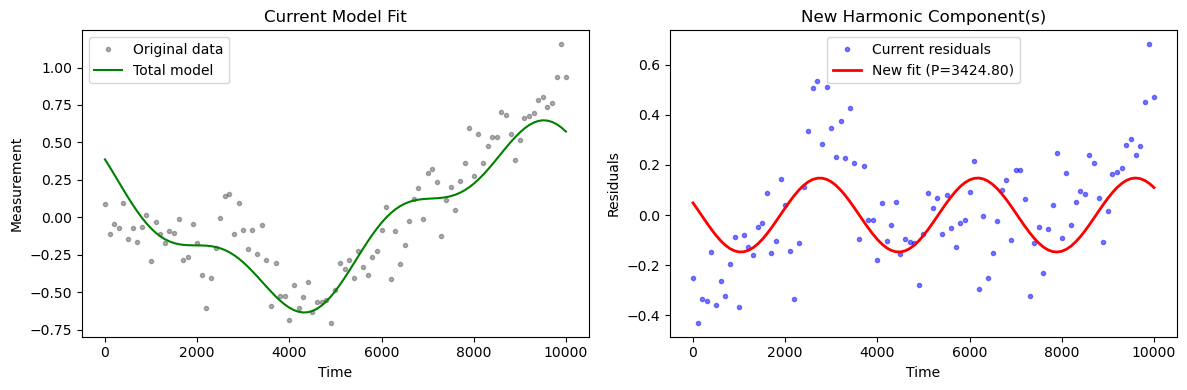


------------------------------------


Keep this result? (y/n/r): r = remake same values :  y



------------------------------------
Fit accepted.


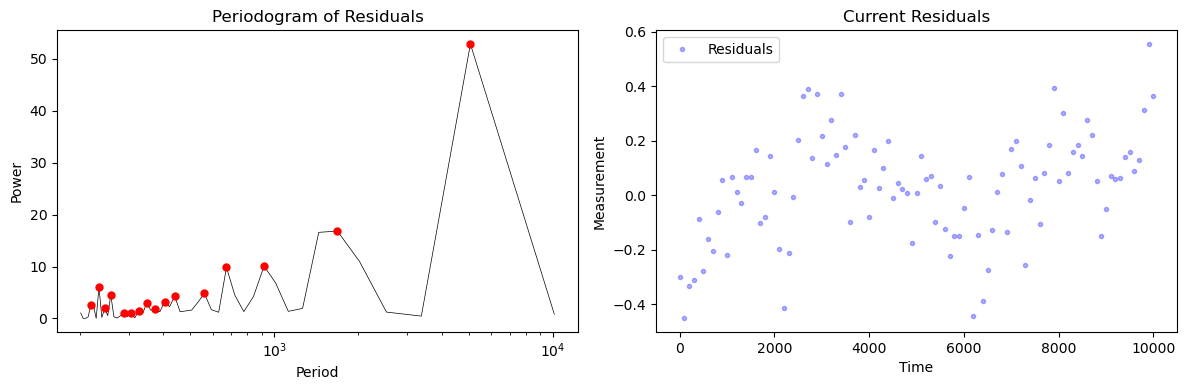


------------------------------------

Possible Peaks sorted by power:
0: 5050.00 (power: 52.88)
1: 1683.33 (power: 16.84)
2: 918.18 (power: 10.07)
3: 673.33 (power: 9.83)
4: 234.88 (power: 6.05)
5: 561.11 (power: 4.85)
6: 258.97 (power: 4.53)
7: 439.13 (power: 4.30)
8: 404.00 (power: 3.23)
9: 348.28 (power: 2.99)

------------------------------------

N inferred harmonics: 2
Of periods:
  1: 10718
  2: 3425

------------------------------------



Select (0-9)  Use '-1' to finish. Use 'd' to switch to double harmonics mode:  0


Initializing NUTS using jitter+adapt_diag...



Selected period: 5050.00 (power: 52.88)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, phi, sigma, P]


Output()

Sampling 4 chains for 20_000 tune and 50_000 draw iterations (80_000 + 200_000 draws total) took 47 seconds.


           mean       sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
P      5272.569  130.949  5023.767  5517.087      0.397    0.286  108881.0   
A         0.150    0.024     0.103     0.195      0.000    0.000  142929.0   
phi       2.245    0.229     1.820     2.676      0.001    0.001  108145.0   
sigma     0.169    0.012     0.146     0.193      0.000    0.000  135014.0   

       ess_tail  r_hat  
P      128065.0    1.0  
A      104787.0    1.0  
phi    119786.0    1.0  
sigma  130038.0    1.0  


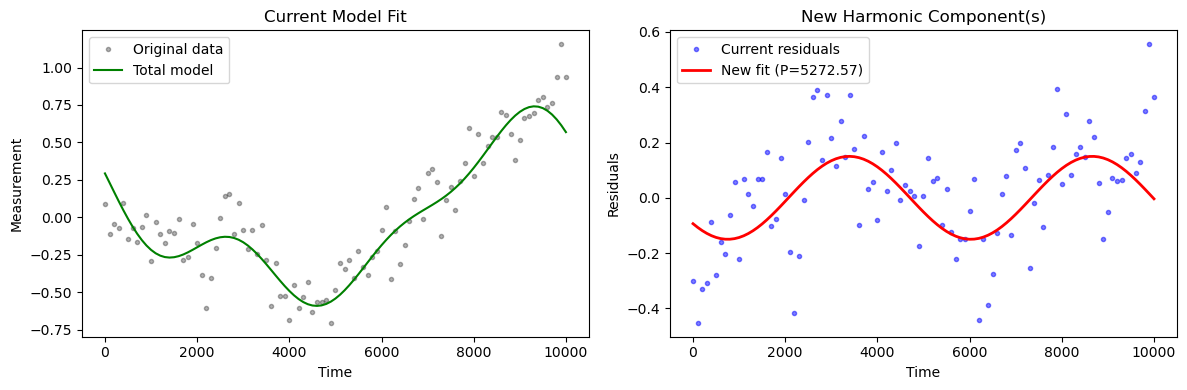


------------------------------------


Keep this result? (y/n/r): r = remake same values :  y



------------------------------------
Fit accepted.


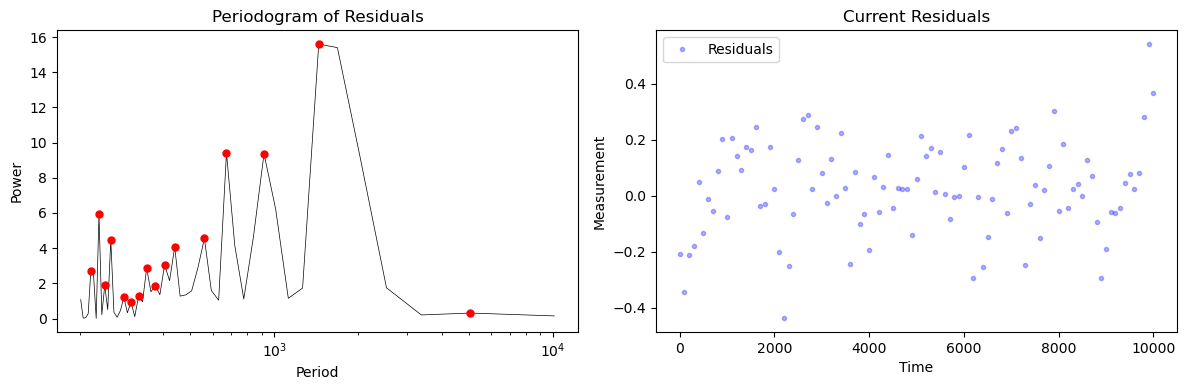


------------------------------------

Possible Peaks sorted by power:
0: 1442.86 (power: 15.60)
1: 673.33 (power: 9.43)
2: 918.18 (power: 9.37)
3: 234.88 (power: 5.93)
4: 561.11 (power: 4.55)
5: 258.97 (power: 4.48)
6: 439.13 (power: 4.07)
7: 404.00 (power: 3.04)
8: 348.28 (power: 2.87)
9: 219.57 (power: 2.68)

------------------------------------

N inferred harmonics: 3
Of periods:
  1: 10718
  2: 3425
  3: 5273

------------------------------------



Select (0-9)  Use '-1' to finish. Use 'd' to switch to double harmonics mode:  0


Initializing NUTS using jitter+adapt_diag...



Selected period: 1442.86 (power: 15.60)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, phi, sigma, P]


Output()

Sampling 4 chains for 20_000 tune and 50_000 draw iterations (80_000 + 200_000 draws total) took 51 seconds.


           mean      sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
P      1420.939  22.955  1377.706  1464.071      0.077    0.067   89609.0   
A         0.073   0.023     0.029     0.117      0.000    0.000   83589.0   
phi       0.501   0.492    -0.431     1.424      0.002    0.001   90165.0   
sigma     0.159   0.011     0.139     0.181      0.000    0.000  123599.0   

       ess_tail  r_hat  
P      105128.0    1.0  
A       49854.0    1.0  
phi     99592.0    1.0  
sigma  123950.0    1.0  


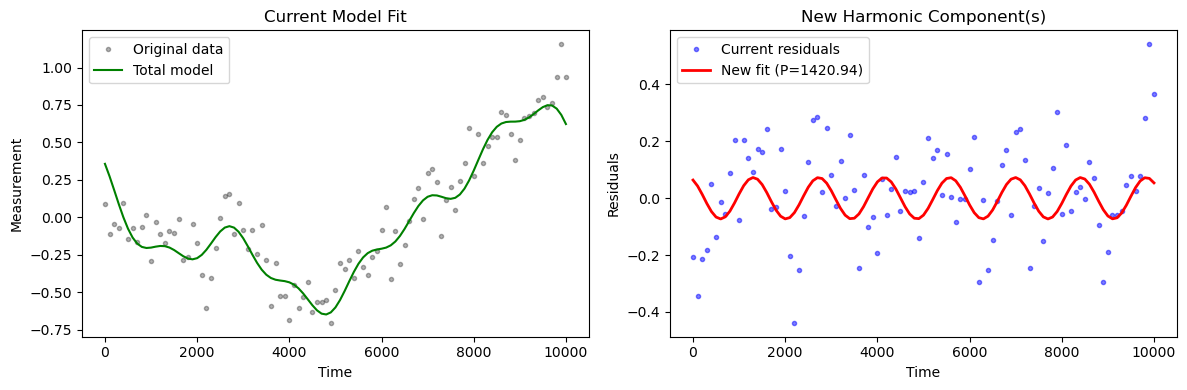


------------------------------------


Keep this result? (y/n/r): r = remake same values :  y



------------------------------------
Fit accepted.


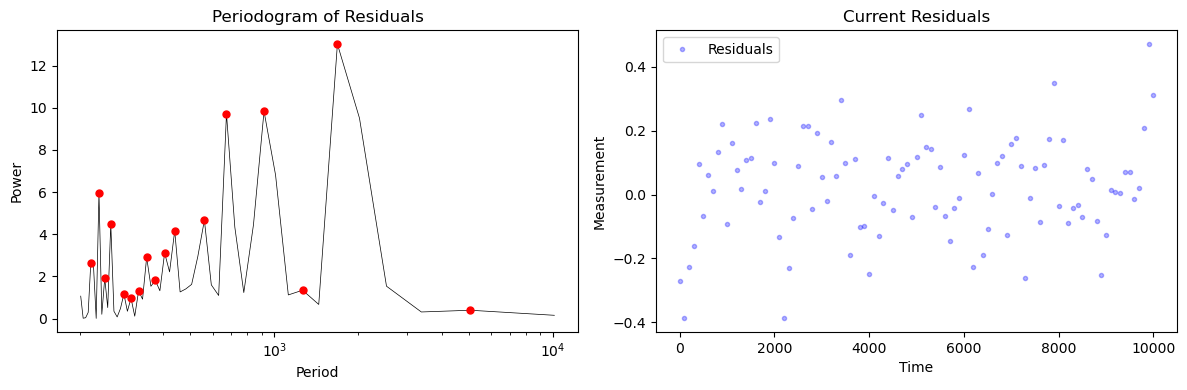


------------------------------------

Possible Peaks sorted by power:
0: 1683.33 (power: 13.02)
1: 918.18 (power: 9.83)
2: 673.33 (power: 9.72)
3: 234.88 (power: 5.98)
4: 561.11 (power: 4.67)
5: 258.97 (power: 4.49)
6: 439.13 (power: 4.17)
7: 404.00 (power: 3.11)
8: 348.28 (power: 2.91)
9: 219.57 (power: 2.65)

------------------------------------

N inferred harmonics: 4
Of periods:
  1: 10718
  2: 3425
  3: 5273
  4: 1421

------------------------------------



Select (0-9)  Use '-1' to finish. Use 'd' to switch to double harmonics mode:  0


Initializing NUTS using jitter+adapt_diag...



Selected period: 1683.33 (power: 13.02)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, phi, sigma, P]


Output()

Sampling 4 chains for 20_000 tune and 50_000 draw iterations (80_000 + 200_000 draws total) took 51 seconds.


           mean      sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
P      1696.585  33.509  1631.504  1757.989      0.117    0.090   83267.0   
A         0.066   0.023     0.022     0.111      0.000    0.000   70331.0   
phi       1.204   0.527     0.192     2.162      0.002    0.002   72088.0   
sigma     0.151   0.011     0.130     0.171      0.000    0.000  105575.0   

       ess_tail  r_hat  
P       97597.0    1.0  
A       40899.0    1.0  
phi     73061.0    1.0  
sigma  109476.0    1.0  


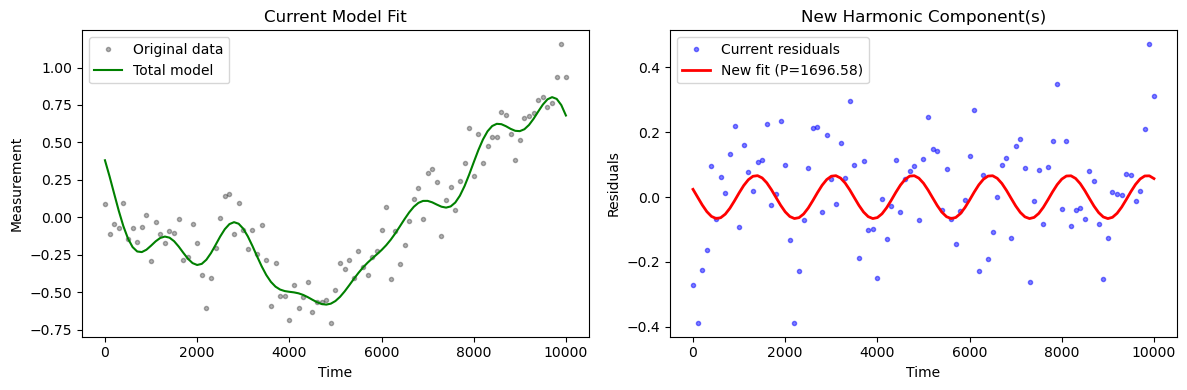


------------------------------------


Keep this result? (y/n/r): r = remake same values :  y



------------------------------------
Fit accepted.


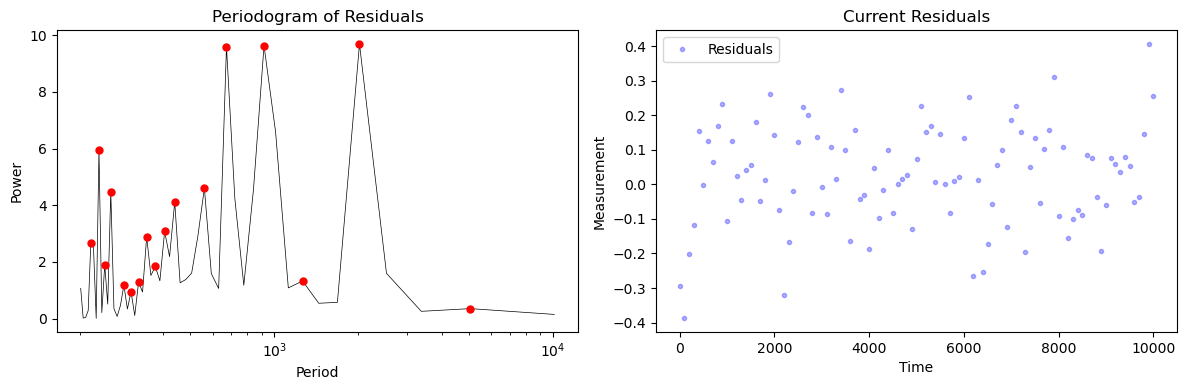


------------------------------------

Possible Peaks sorted by power:
0: 2020.00 (power: 9.69)
1: 918.18 (power: 9.63)
2: 673.33 (power: 9.60)
3: 234.88 (power: 5.95)
4: 561.11 (power: 4.61)
5: 258.97 (power: 4.48)
6: 439.13 (power: 4.12)
7: 404.00 (power: 3.08)
8: 348.28 (power: 2.88)
9: 219.57 (power: 2.66)

------------------------------------

N inferred harmonics: 5
Of periods:
  1: 10718
  2: 3425
  3: 5273
  4: 1421
  5: 1697

------------------------------------



Select (0-9)  Use '-1' to finish. Use 'd' to switch to double harmonics mode:  0


Initializing NUTS using jitter+adapt_diag...



Selected period: 2020.00 (power: 9.69)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, phi, sigma, P]


Output()

Sampling 4 chains for 20_000 tune and 50_000 draw iterations (80_000 + 200_000 draws total) took 79 seconds.
There were 4182 divergences after tuning. Increase `target_accept` or reparameterize.


           mean      sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
P      2092.583  55.204  1983.888  2191.282      1.077    0.560    2498.0   
A         0.069   0.025     0.014     0.114      0.000    0.000    4248.0   
phi       1.271   2.277    -3.047     3.139      0.031    0.022   10265.0   
sigma     0.140   0.011     0.121     0.160      0.000    0.000    3108.0   

       ess_tail  r_hat  
P        3663.0    1.0  
A        8784.0    1.0  
phi     17602.0    1.0  
sigma    5282.0    1.0  


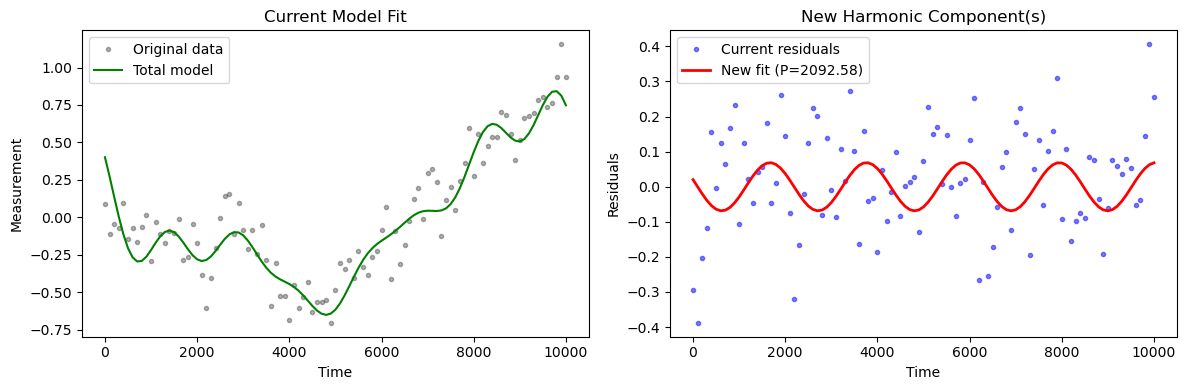


------------------------------------


Keep this result? (y/n/r): r = remake same values :  y



------------------------------------
Fit accepted.


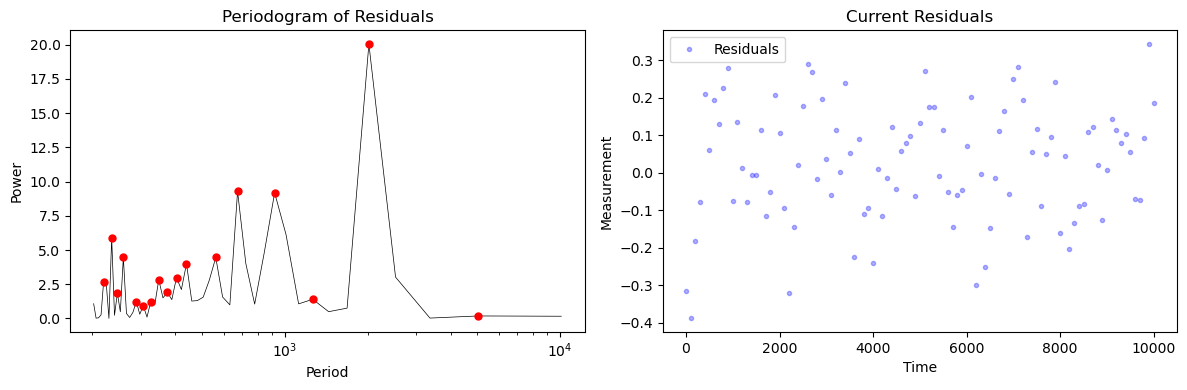


------------------------------------

Possible Peaks sorted by power:
0: 2020.00 (power: 20.04)
1: 673.33 (power: 9.28)
2: 918.18 (power: 9.18)
3: 234.88 (power: 5.88)
4: 258.97 (power: 4.46)
5: 561.11 (power: 4.45)
6: 439.13 (power: 3.99)
7: 404.00 (power: 2.98)
8: 348.28 (power: 2.83)
9: 219.57 (power: 2.70)

------------------------------------

N inferred harmonics: 6
Of periods:
  1: 10718
  2: 3425
  3: 5273
  4: 1421
  5: 1697
  6: 2093

------------------------------------



Select (0-9)  Use '-1' to finish. Use 'd' to switch to double harmonics mode:  -1


Finished fitting.


In [15]:
borneo_more_harmonics= interactive_fit(t_b, y_b, Pmin=400, Pmax=10000, l_s=False, n_samples=50000, n_tune=20000, target_accept=0.95)

The LAST fit produce an harmonic of Period 2020 witch on the following step gets repeated: that harmonic is an artifact.
5 is the optimal numeber of harmonics

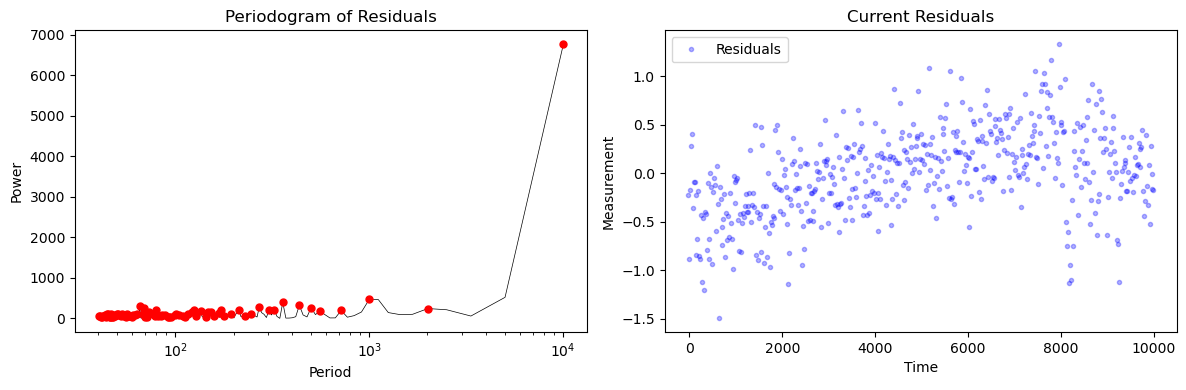


------------------------------------

Possible Peaks sorted by power:
0: 10045.02 (power: 6776.19)
1: 1004.50 (power: 478.17)
2: 358.75 (power: 397.02)
3: 436.74 (power: 326.00)
4: 65.65 (power: 312.13)
5: 271.49 (power: 284.80)
6: 502.25 (power: 265.64)
7: 69.28 (power: 256.20)
8: 2009.00 (power: 243.38)
9: 324.03 (power: 216.06)

------------------------------------

N inferred harmonics: 0

------------------------------------



Select (0-9)  Use '-1' to finish. Use 'd' to switch to double harmonics mode:  0


Initializing NUTS using jitter+adapt_diag...



Selected period: 10045.02 (power: 6776.19)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, phi, sigma, P]


Output()

Sampling 4 chains for 20_000 tune and 50_000 draw iterations (80_000 + 200_000 draws total) took 92 seconds.


            mean       sd     hdi_3%    hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
P      10554.886  236.630  10111.549  11001.119      0.728    0.517  105669.0   
A          0.331    0.024      0.287      0.375      0.000    0.000  164425.0   
phi        2.378    0.103      2.185      2.571      0.000    0.000  110221.0   
sigma      0.375    0.012      0.353      0.398      0.000    0.000  169259.0   

       ess_tail  r_hat  
P      125883.0    1.0  
A      131303.0    1.0  
phi    132502.0    1.0  
sigma  138066.0    1.0  


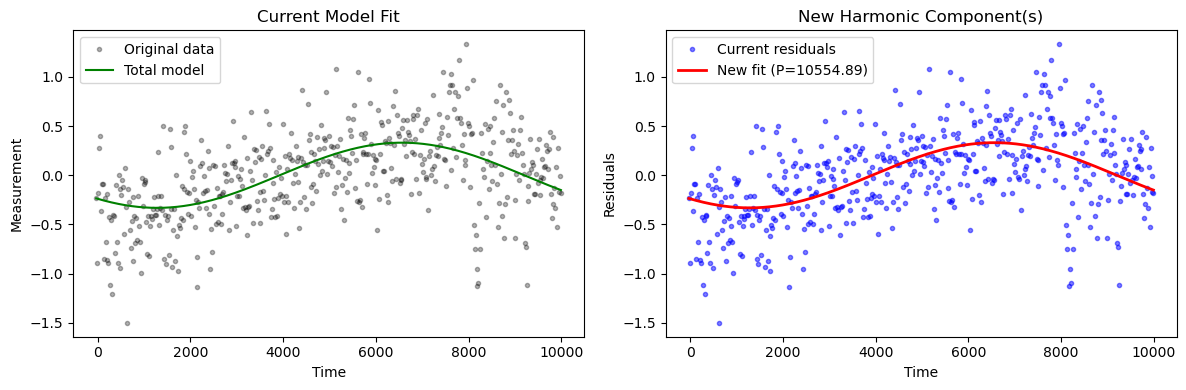


------------------------------------


Keep this result? (y/n/r): r = remake same values :  y



------------------------------------
Fit accepted.


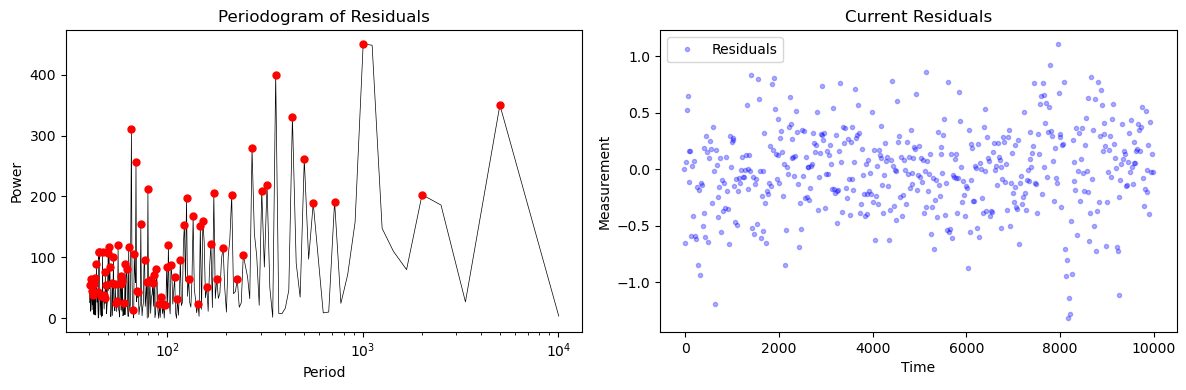


------------------------------------

Possible Peaks sorted by power:
0: 1004.50 (power: 450.05)
1: 358.75 (power: 400.09)
2: 5022.51 (power: 349.97)
3: 436.74 (power: 330.64)
4: 65.65 (power: 310.49)
5: 271.49 (power: 279.01)
6: 502.25 (power: 261.25)
7: 69.28 (power: 257.14)
8: 324.03 (power: 219.01)
9: 79.72 (power: 211.73)

------------------------------------

N inferred harmonics: 1
Of periods:
  1: 10555

------------------------------------



Select (0-9)  Use '-1' to finish. Use 'd' to switch to double harmonics mode:  0


Initializing NUTS using jitter+adapt_diag...



Selected period: 1004.50 (power: 450.05)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, phi, sigma, P]


Output()

Sampling 4 chains for 20_000 tune and 50_000 draw iterations (80_000 + 200_000 draws total) took 98 seconds.


          mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
P      977.295  13.794  955.297  998.565      0.163    0.583   39477.0   
A        0.088   0.024    0.042    0.133      0.000    0.000   90067.0   
phi      0.512   0.533   -0.488    1.510      0.002    0.002   74692.0   
sigma    0.369   0.012    0.347    0.392      0.000    0.000  123446.0   

       ess_tail  r_hat  
P       18925.0    1.0  
A       60255.0    1.0  
phi     56024.0    1.0  
sigma  109564.0    1.0  


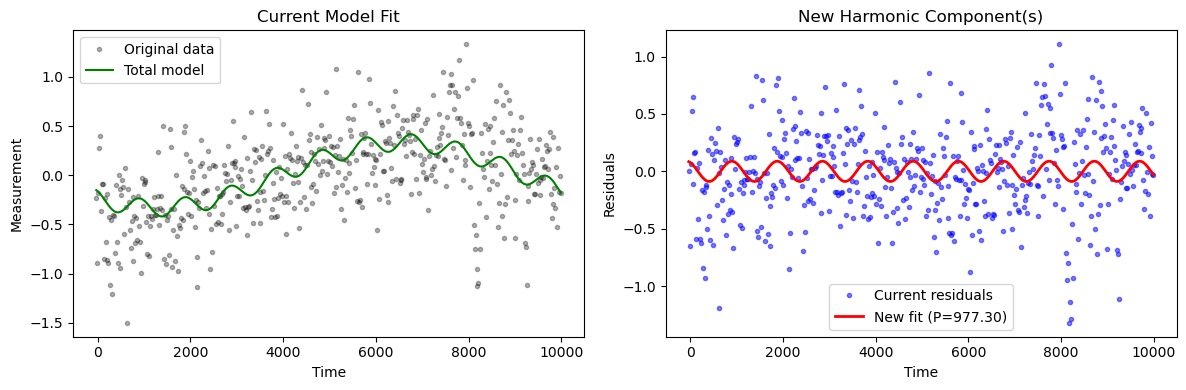


------------------------------------


Keep this result? (y/n/r): r = remake same values :  y



------------------------------------
Fit accepted.


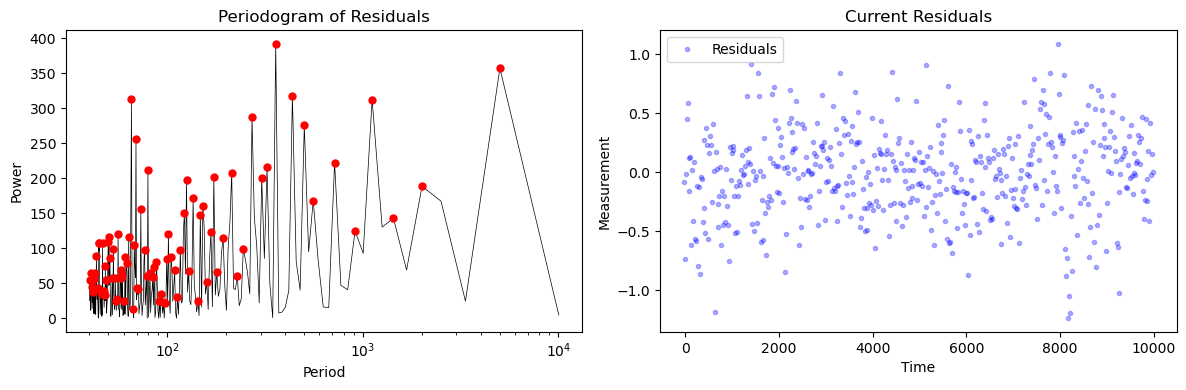


------------------------------------

Possible Peaks sorted by power:
0: 358.75 (power: 391.93)
1: 5022.51 (power: 357.36)
2: 436.74 (power: 318.03)
3: 65.65 (power: 312.89)
4: 1116.11 (power: 312.43)
5: 271.49 (power: 288.14)
6: 502.25 (power: 275.81)
7: 69.28 (power: 255.78)
8: 717.50 (power: 222.63)
9: 324.03 (power: 215.70)

------------------------------------

N inferred harmonics: 2
Of periods:
  1: 10555
  2: 977

------------------------------------



Select (0-9)  Use '-1' to finish. Use 'd' to switch to double harmonics mode:  1


Initializing NUTS using jitter+adapt_diag...



Selected period: 5022.51 (power: 357.36)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, phi, sigma, P]


Output()

Sampling 4 chains for 20_000 tune and 50_000 draw iterations (80_000 + 200_000 draws total) took 155 seconds.
There were 8606 divergences after tuning. Increase `target_accept` or reparameterize.


           mean       sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
P      5040.795  144.987  4759.207  5307.265      3.357    2.033    1873.0   
A         0.065    0.027     0.004     0.108      0.001    0.000    1748.0   
phi       2.036    0.902     0.825     3.142      0.011    0.016    7007.0   
sigma     0.366    0.011     0.344     0.387      0.000    0.000    2228.0   

       ess_tail  r_hat  
P        1452.0    1.0  
A        5003.0    1.0  
phi      9037.0    1.0  
sigma    6534.0    1.0  



------------------------------------


Keep this result? (y/n/r): r = remake same values :  y



------------------------------------
Fit accepted.


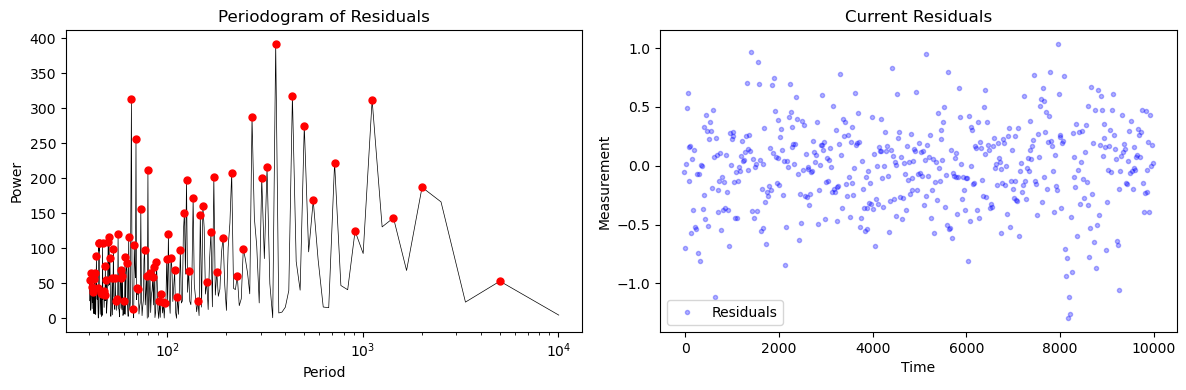


------------------------------------

Possible Peaks sorted by power:
0: 358.75 (power: 392.04)
1: 436.74 (power: 318.19)
2: 65.65 (power: 312.83)
3: 1116.11 (power: 312.08)
4: 271.49 (power: 287.94)
5: 502.25 (power: 275.64)
6: 69.28 (power: 255.81)
7: 717.50 (power: 222.44)
8: 324.03 (power: 215.79)
9: 79.72 (power: 212.28)

------------------------------------

N inferred harmonics: 3
Of periods:
  1: 10555
  2: 977
  3: 5041

------------------------------------



Select (0-9)  Use '-1' to finish. Use 'd' to switch to double harmonics mode:  0


Initializing NUTS using jitter+adapt_diag...



Selected period: 358.75 (power: 392.04)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, phi, sigma, P]


Output()

Sampling 4 chains for 20_000 tune and 50_000 draw iterations (80_000 + 200_000 draws total) took 262 seconds.
There were 310 divergences after tuning. Increase `target_accept` or reparameterize.


          mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
P      360.169  6.227  346.450  369.810      0.079    0.214   15790.0   
A        0.059  0.028    0.000    0.102      0.000    0.000    8082.0   
phi     -1.141  1.007   -2.914    0.656      0.008    0.006   16147.0   
sigma    0.363  0.011    0.342    0.385      0.000    0.000    7951.0   

       ess_tail  r_hat  
P        7263.0    1.0  
A       13948.0    1.0  
phi     37804.0    1.0  
sigma   12600.0    1.0  


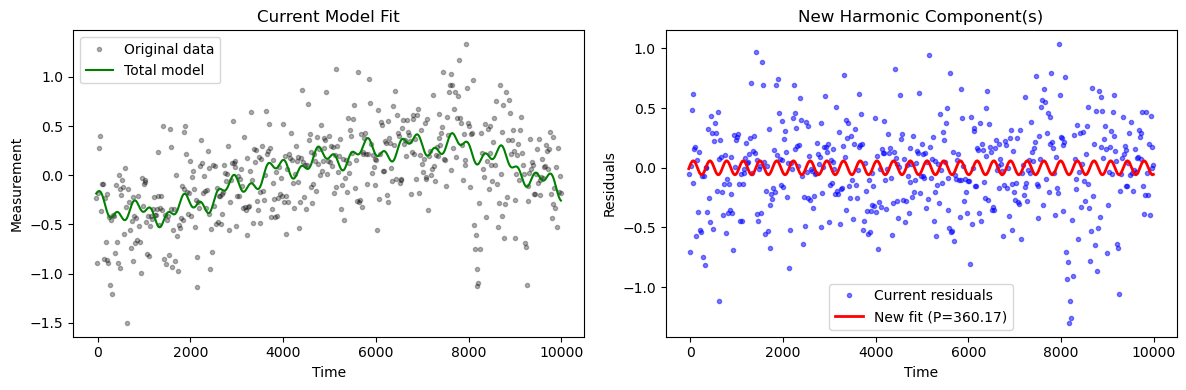


------------------------------------


Keep this result? (y/n/r): r = remake same values :  y



------------------------------------
Fit accepted.


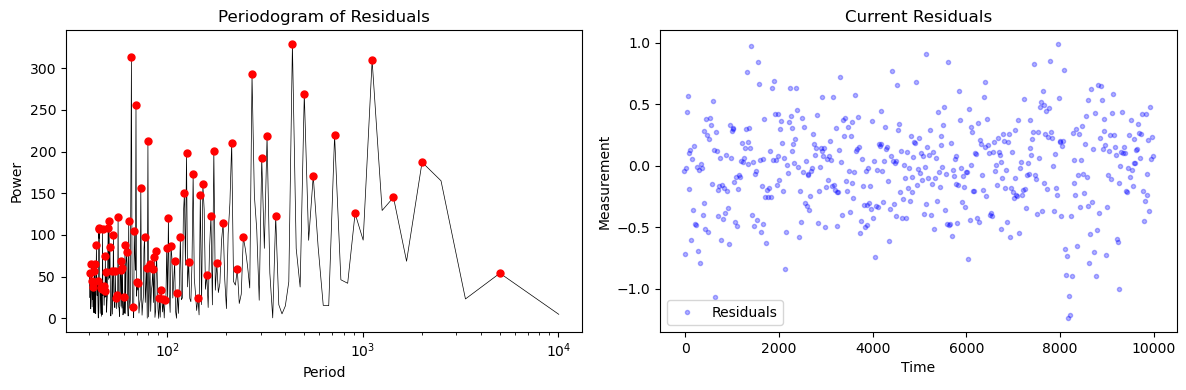


------------------------------------

Possible Peaks sorted by power:
0: 436.74 (power: 328.86)
1: 65.65 (power: 313.57)
2: 1116.11 (power: 309.17)
3: 271.49 (power: 292.56)
4: 502.25 (power: 269.53)
5: 69.28 (power: 255.50)
6: 717.50 (power: 219.25)
7: 324.03 (power: 218.18)
8: 79.72 (power: 212.53)
9: 213.72 (power: 210.46)

------------------------------------

N inferred harmonics: 4
Of periods:
  1: 10555
  2: 977
  3: 5041
  4: 360

------------------------------------



Select (0-9)  Use '-1' to finish. Use 'd' to switch to double harmonics mode:  0



Selected period: 436.74 (power: 328.86)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, phi, sigma, P]


Output()

Sampling 4 chains for 20_000 tune and 50_000 draw iterations (80_000 + 200_000 draws total) took 90 seconds.


          mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
P      443.124  7.414  433.213  465.339      0.052    0.081   30689.0   
A        0.060  0.026    0.006    0.105      0.000    0.000   36716.0   
phi     -1.000  0.664   -2.192    0.247      0.004    0.004   39809.0   
sigma    0.360  0.012    0.338    0.382      0.000    0.000   86946.0   

       ess_tail  r_hat  
P       15815.0    1.0  
A       29391.0    1.0  
phi     38985.0    1.0  
sigma   95784.0    1.0  


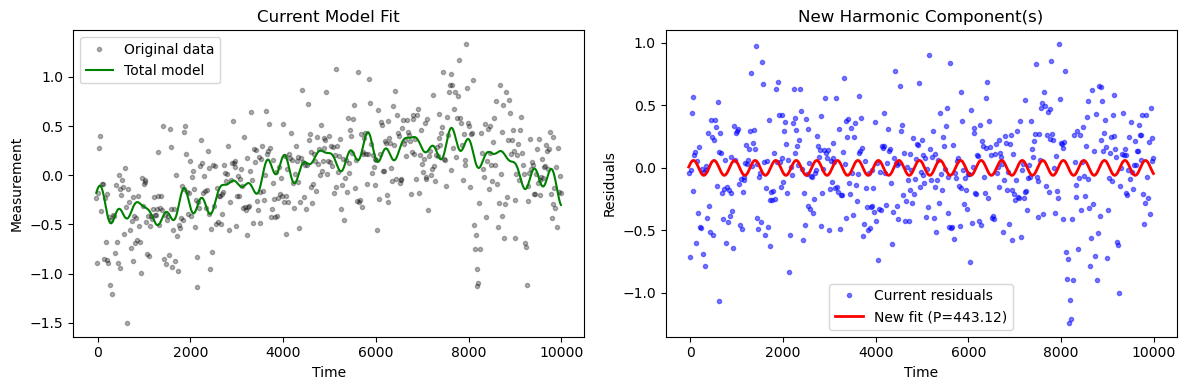


------------------------------------


Keep this result? (y/n/r): r = remake same values :  y



------------------------------------
Fit accepted.


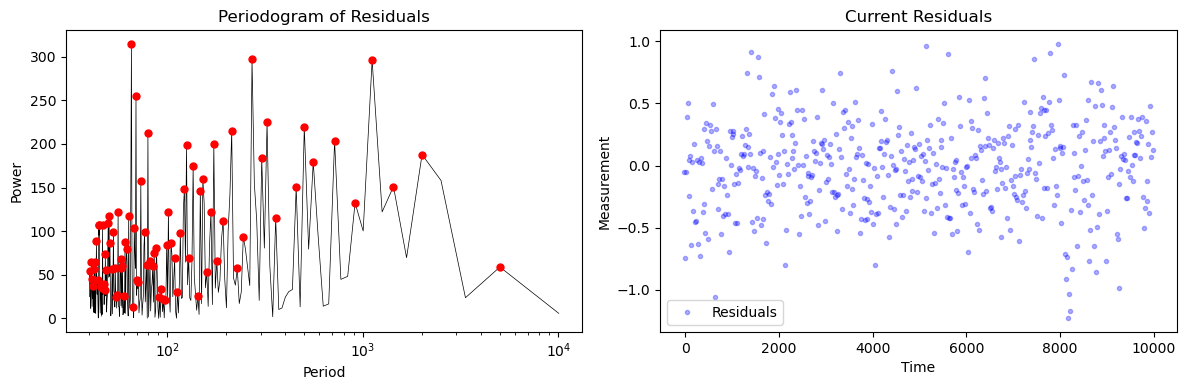


------------------------------------

Possible Peaks sorted by power:
0: 65.65 (power: 314.60)
1: 271.49 (power: 297.13)
2: 1116.11 (power: 296.12)
3: 69.28 (power: 255.08)
4: 324.03 (power: 224.72)
5: 502.25 (power: 219.66)
6: 213.72 (power: 214.50)
7: 79.72 (power: 212.97)
8: 717.50 (power: 203.49)
9: 173.19 (power: 200.30)

------------------------------------

N inferred harmonics: 5
Of periods:
  1: 10555
  2: 977
  3: 5041
  4: 360
  5: 443

------------------------------------



Select (0-9)  Use '-1' to finish. Use 'd' to switch to double harmonics mode:  2


Initializing NUTS using jitter+adapt_diag...



Selected period: 1116.11 (power: 296.12)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, phi, sigma, P]


Output()

Sampling 4 chains for 20_000 tune and 50_000 draw iterations (80_000 + 200_000 draws total) took 77 seconds.


           mean      sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
P      1096.238  17.465  1063.439  1128.970      0.060    0.058   86308.0   
A         0.067   0.023     0.022     0.111      0.000    0.000   76121.0   
phi       0.019   0.580    -1.089     1.094      0.002    0.002   89961.0   
sigma     0.356   0.011     0.335     0.378      0.000    0.000  118624.0   

       ess_tail  r_hat  
P       92695.0    1.0  
A       43970.0    1.0  
phi    100341.0    1.0  
sigma  114695.0    1.0  


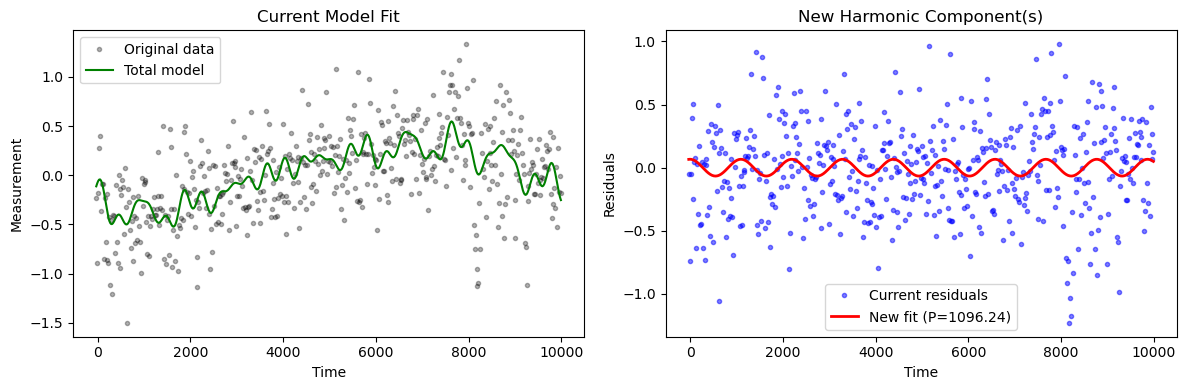


------------------------------------


Keep this result? (y/n/r): r = remake same values :  y



------------------------------------
Fit accepted.


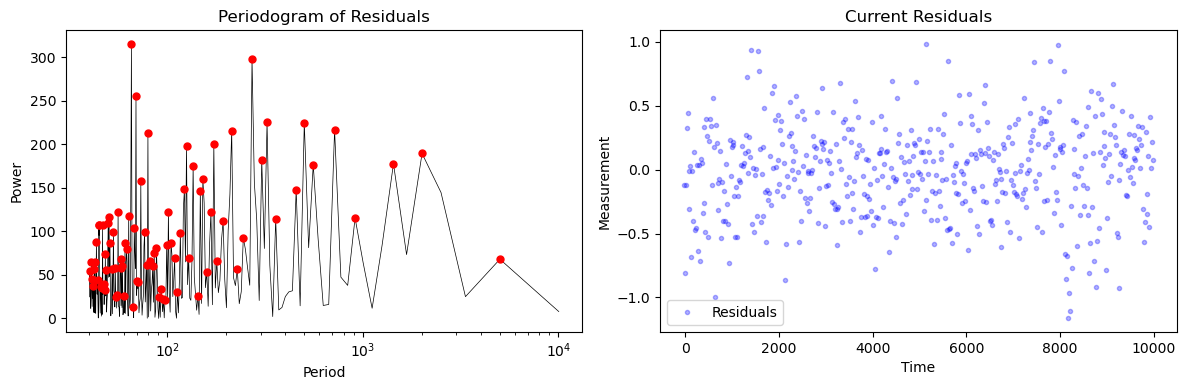


------------------------------------

Possible Peaks sorted by power:
0: 65.65 (power: 314.97)
1: 271.49 (power: 298.37)
2: 69.28 (power: 254.91)
3: 324.03 (power: 225.50)
4: 502.25 (power: 224.77)
5: 717.50 (power: 216.49)
6: 213.72 (power: 215.63)
7: 79.72 (power: 213.10)
8: 173.19 (power: 199.97)
9: 125.56 (power: 198.39)

------------------------------------

N inferred harmonics: 6
Of periods:
  1: 10555
  2: 977
  3: 5041
  4: 360
  5: 443
  6: 1096

------------------------------------



Select (0-9)  Use '-1' to finish. Use 'd' to switch to double harmonics mode:  -1


Finished fitting.


In [22]:
d18o_f = interactive_fit(t, y, Pmin= 400, Pmax=10000, l_s=False, n_samples=50000, n_tune=20000, target_accept=0.95)

## Results

##### Tables

In [14]:
table_borneo = borneo["param"]
table_borneo.sort_values("period",ascending=[False])

period    s_period  amplitude  s_amplitude       phi     s_phi
0  10718.378819  236.838769   0.506526     0.033480  0.839430  0.093580
2   5272.170473  130.719141   0.150130     0.024206  2.243977  0.229163
1   3424.990249   72.217688   0.147951     0.029197  1.238288  0.259677
4   1696.366561   33.616672   0.066395     0.023401  1.199854  0.527281
3   1421.193165   22.933516   0.072727     0.023469  0.504613  0.492540

In [12]:
table_o18 = l_s["param"]
table_o18.sort_values("period",ascending=[False])

period    s_period  amplitude  s_amplitude       phi     s_phi
0  13031.447769  368.255173   0.325351     0.023712  2.775024  1.023872
6  10739.565243  323.766396   0.059247     0.027238  4.367200  0.830723
3   4231.622481  116.440293   0.066362     0.025591  1.713279  0.586359
5   1469.880247   36.794769   0.054212     0.024233  5.467989  0.864838
4   1091.442514   18.718377   0.058738     0.023595  6.092347  0.617964
1    968.535206   11.670045   0.081429     0.024594  0.211194  0.528973
7    603.277954    9.850089   0.052450     0.023592  0.072236  0.560364
8    497.556309   10.010248   0.049803     0.023725  0.372087  0.626275
2    444.543563    8.381790   0.059147     0.026580  5.389639  0.655277

In [23]:
table_fourier = d18o_f["param"]
table_fourier.sort_values("period",ascending=[False])

period    s_period  amplitude  s_amplitude       phi     s_phi
0  10554.885668  236.628999   0.331197     0.023557  2.378318  0.102667
2   5040.794511  144.986801   0.065472     0.026867  2.035946  0.901912
5   1096.238426   17.465295   0.066591     0.023254  0.019163  0.580421
1    977.295281   13.794327   0.088099     0.024244  0.511738  0.532657
4    443.123666    7.414008   0.059939     0.026281  5.283481  0.664234
3    360.168579    6.227156   0.058709     0.028336  5.142132  1.007108

##### Plots

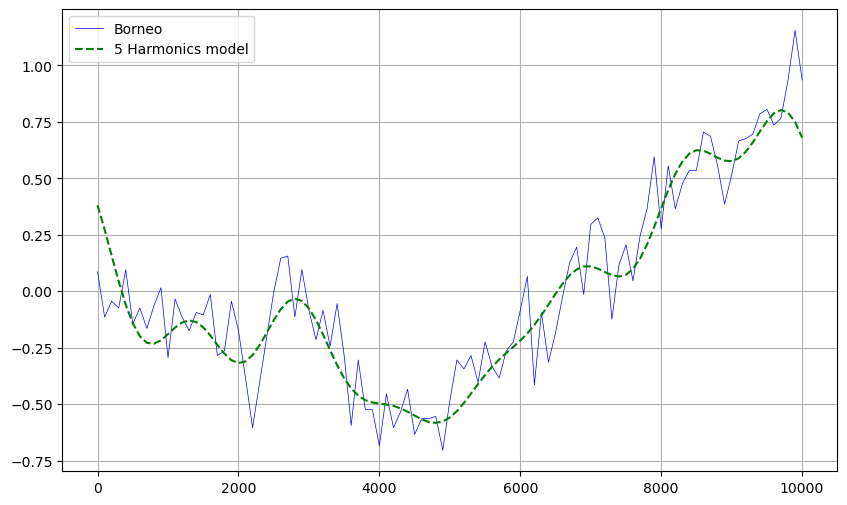

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(t_b, y_b, label="Borneo", color="blue", linewidth=0.5)
plt.plot(t_b, borneo["final_model"], label="5 Harmonics model", color="green", linestyle="--", linewidth=1.5)
plt.legend()
plt.grid(True)
plt.show()

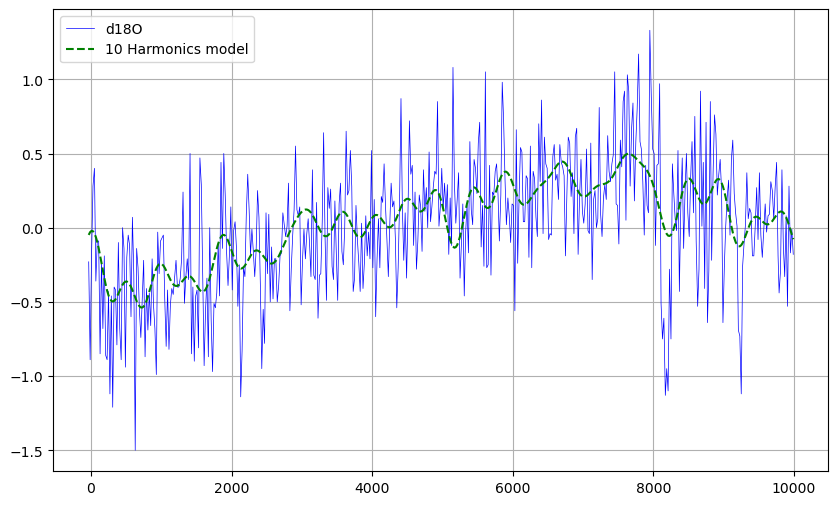

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(t, y, label="d18O", color="blue", linewidth=0.5)
plt.plot(t, l_s["final_model"], label="10 Harmonics model", color="green", linestyle="--", linewidth=1.5)
plt.legend()
plt.grid(True)
plt.show()

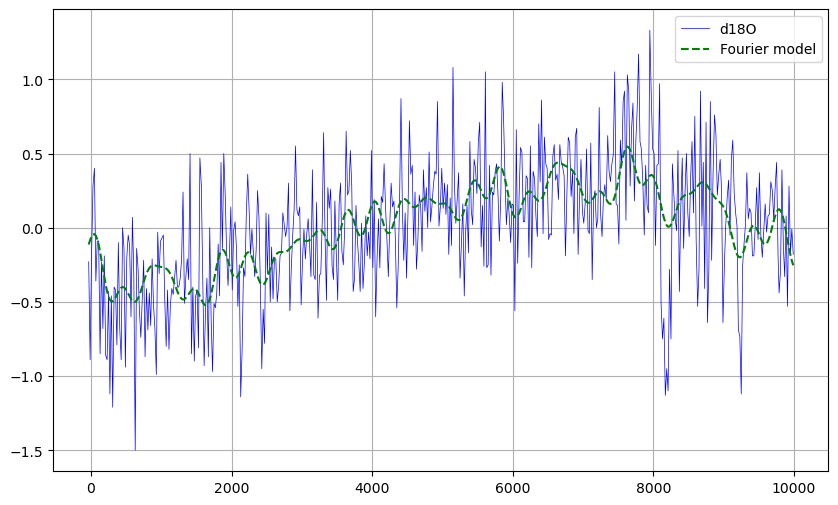

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(t, y, label="d18O", color="blue", linewidth=0.5)
plt.plot(t, d18o_f["final_model"], label="Fourier model", color="green", linestyle="--", linewidth=1.5)
plt.legend()
plt.grid(True)
plt.show()

- The harmonics below $P=400$ seems to be aliases; the algorithm seems to capture a lot of frequencies below N-S freq
- Escluded $P=5k$ and $P=10k$ all the other harmonics seems to be quite close to eachother.

(All values are just dimensionalities not exact values with an interval)

**Comparison Fourier Lom-Scarble** 
- Both fits seems reasonable on the data
- Fourier has less harmonics (so lesser parameters)
- Only the 10k and 5k matches the Borneo harmonics
- Lomb_scarble detect a peak of $P=4.2k$ that could be interpreted as a mix between the $P=5k$ and $P=3.6k$ meaning the algorithm doesnt have enough data to correctly separate them both.
- Lomb_scarble detects the $P=1.4k$ and more mid-high range signals presents in the data suggesting a better adaptation against aliasing artifacts compared to Fourier model.
- NONE of the protocols used has managed to extract the $P=6.5k$ given as true value in the data. 